# 08MIAR - Aprendizaje Por Refuerzo: Proyecto de programación "*Entrenamiento Agente Para Space Invaders*"



---


##### Autores:    Daniel Romero Martinez / Roberto Vazquez Calvo / Pere Marc Monserrat Calbo
##### Fecha:      Enero 2026.
##### Titulación: Master Universitario en Inteligencia Artificial - VIU
##### Profesor:   D. Jose Manuel Camacho

---



---
# 0. Introducción

## 0.1. Enunciado del Problema

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga **alcanzar más de 20 puntos con reward clipping durante más de 100 episodios consecutivos**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

## 0.2. Soluciones planteadas
En este trabajo se han desarrollado y evaluado cuatro arquitecturas diferentes:
- DQN básico (Keras)
- Double DQN (Keras)
- Dueling Double DQN (Keras)
- DQN + PER (PyTorch) 

Dato que el notebook es muy extenso, y con el objetivo de mantener las soluciones mas organizadas y legibles, se ha optado por trasladar la mayoria de funciones a ficheros .py.
Al final del notebook se incluyen las librerías utilizadas dentro del apartado de anexos.

---
# 1. Instalación y preparacion del entorno
Todo el codigo que prepara el entorno en base a si estamos en Colab o en Local se ha llevado a una funcion ejecutable para mantener el notebook mas limpio.

In [2]:
# Llamamos a funcion que prepara el entorno.
!python entorno_spaceinvadersv0.py


Estamos en entorno Local: /home/rober/anaconda3/envs/GymClasic/bin/python
Directorio actual: /home/rober/proyectos_python/08MIAR_AprendizajePorRefuerzo/Portfolio/spaceInvaders-v0
Archivos en el directorio:
['draft', 'Solucion1', '.git', 'Solucion4', 'Solucion2', 'entorno_spaceinvadersv0.py', 'Solucion3', 'Anexo_MEMORIA.md', 'torch_functions.py', '__pycache__', '.gitignore', 'img', 'env_functions.py', '.ipynb_checkpoints', '08MIAR_Proyecto_Programacion_G21.ipynb']

La version de Python instalada en este entorno Local es: 3.8

Comprobando Paquetes Instalados....

✔ numpy ya está instalado.
✔ Keras ya está instalado.
✔ keras-rl2 ya está instalado.
✔ tensorflow ya está instalado.
✔ gym ya está instalado.
✔ atari_py ya está instalado.
✔ pyglet ya está instalado.
✔ h5py ya está instalado.
✔ Pillow ya está instalado.
✔ opencv-python-headless ya está instalado.
✔ matplotlib ya está instalado.
✔ torch ya está instalado.
✔ agents ya está instalado.
✔ torchinfo ya está instalado.

El entorno esta

---
# 2. Desarrollo y preguntas

## 2.1 Declaraciones Generales

In [3]:
# Llamada a funciones generales
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Layer, Permute

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory, Memory

from IPython.display import display, Markdown

import torch
import torch.optim as optim
from torchinfo import summary
from collections import deque
from pathlib import Path
import sys

# Llamada a funciones propias
from env_functions import plot_rewards, agent_eval, ShowLastTraining, merge_json_logs
from env_functions import set_seeds, make_env, AtariProcessor, TrainAgent, TestAgent
from env_functions import compara_solutions
import env_functions as ef

from torch_functions import ReplayBufferPER, compute_td_loss_PER, DQNag, update_target
from torch_functions import LogTorch, update_frame_sequence

# Anulamos UserWarnings de TensorFlow
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")


## 2.2 Solución nº1 - DQN
En esta solucion implementamos una arquitectura basada en DQN básico.
<p align="center">
  <img src="img/Single_DQN_img.png" width="600">
</p>

La red Deep Q‑Network (DQN) combina el aprendizaje por refuerzo con redes neuronales profundas para aproximar la función de valor Q, permitiendo que un agente aprenda políticas directamente a partir de imágenes del entorno. La arquitectura recibe como entrada una secuencia de frames preprocesados y genera como salida un valor Q para cada acción posible. Al tratarse de un algoritmo off‑policy, el agente emplea experience replay para almacenar transiciones pasadas y reutilizarlas mediante muestreo aleatorio, reduciendo la correlación entre muestras. Además, se utiliza una target network para estabilizar las actualizaciones de los valores Q, lo que permite un aprendizaje más robusto y consistente en entornos complejos como los juegos Atari.


#### 2.2.1 Configuración base

In [4]:
# Definicion de parametros fijos y carga de los entornos de training & test.
# Parametros fijos
seed = 42
Memory_Size = 500000
N_Solucion = 1
Reward_min = 20
Episodios_min = 100
Training_Steps = 1500000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f"Numero de acciones del juego: {nb_actions}")
print(
    f"Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}"
)
print(f"Dimensiones del Frame del juego: [{height},{width},{channels}]")

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.2.2 Implementación de la red neuronal

In [5]:
# Definimos la arquitectura de red neuronal en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
def BuildDcnn(n_classes=6):
    model = Sequential(name="DQN_CNN")
    # Entrada
    model.add(Permute((2, 3, 1), input_shape=(ef.WINDOW_LENGTH,) + ef.INPUT_SHAPE))

    # Base Model - Bloque convolucional
    model.add(
        Conv2D(
            16, (8, 8), strides=(4, 4), padding="valid", activation="relu", name="conv1"
        )
    )
    model.add(
        Conv2D(
            32, (4, 4), strides=(2, 2), padding="valid", activation="relu", name="conv2"
        )
    )
    model.add(
        Conv2D(
            32, (3, 3), strides=(1, 1), padding="valid", activation="relu", name="conv3"
        )
    )

    # Top Model - Capa FC.
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation="relu", name="fc_shared"))

    # Capa final: Q(s,a)
    model.add(Dense(n_classes, activation="linear", name="Q_values"))

    return model


# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
model.summary()

Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6
Model: "DQN_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 9, 32)          8224      
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
fc_shared (Dense)            (None, 128)               200832    
____________________________________________________

#### 2.2.3 Implementación de la solución DQN

In [7]:
# Definimos nuestro agente: Buffer memoria, policy y tipo agente.
def BuildAgent(model, memory_size, tr_steps, n_actions, lr=0.0005):

    # Preparación de la memoria (usamos memory replay en DQN).
    ReplayBuffer = SequentialMemory(limit=memory_size, window_length=ef.WINDOW_LENGTH)

    # Llamamos a clase para pre-procesado de las observaciones.
    processor = AtariProcessor()

    # Definimos la policy, estrategia para seleccionar las acciones. Decide que accion tomar.
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),  # Estrategia E-greedy.
        attr="eps",
        value_max=1.0,  # Explora totalmente al inicio
        value_min=0.05,  # Explora poco al final del entrenamiento
        value_test=0.05,  # Exploración mínima en test
        nb_steps=tr_steps,  # Duración del decaimiento
    )

    # Definición del agente DQN. Aqui se junta todo, es el cerebro que coordina todo.
    # Llama a la ANN para estimar la Q, aplica la policy para elegir la acción, interactua con el entorno y usa el replay bufer para guardar las experiencias,
    # entrena la red mediante el target network para estabilizar el aprendizaje y la actualiza con la función de perdidas.
    dqn = DQNAgent(
        model=model,  # La red CNN que estima la distribución Q
        nb_actions=n_actions,  # Número de acciones posibles en el entorno
        memory=ReplayBuffer,  # Replay buffer para almacenar transiciones
        policy=policy,  # Política/Estrategia
        processor=processor,  # Preprocesado de observaciones
        nb_steps_warmup=50000,  # Pasos iniciales solo explorando (sin entrenar)
        target_model_update=10000,  # Frecuencia de actualización del target network
        train_interval=4,  # Entrenar cada X pasos de interacción
        gamma=0.99,  # Factor de descuento para recompensas futuras
    )

    # Compilación del agente
    dqn.compile(Adam(learning_rate=lr, clipnorm=10.0), metrics=["mae"])

    # Mostrar confirmacion
    print("Agente creado con exito.")

    return dqn


# Construimos el agente.
agent = BuildAgent(model, Memory_Size, Training_Steps, nb_actions, 0.00025)

Agente creado con exito.


#### 2.2.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.2.4.1 Etapa 1: Entrenamiento desde 0 con 1.5M steps

Cargando pesos: Solucion1/dqn1_SpaceInvaders-v0_weights_final_1.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 861s 9ms/step - reward: 3.4221
1713 episodes - episode_reward: 3.422 [0.000, 24.000] - loss: 0.029 - mae: 0.719 - mean_q: 0.900 - mean_eps: 0.952
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 1541s 15ms/step - reward: 3.9398
1628 episodes - episode_reward: 3.940 [0.000, 23.000] - loss: 0.041 - mae: 1.514 - mean_q: 1.899 - mean_eps: 0.906
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 1686s 17ms/step - reward: 4.6947
1474 episodes - episode_reward: 4.695 [0.000, 28.000] - loss: 0.074 - mae: 2.711 - mean_q: 3.364 - mean_eps: 0.842
---

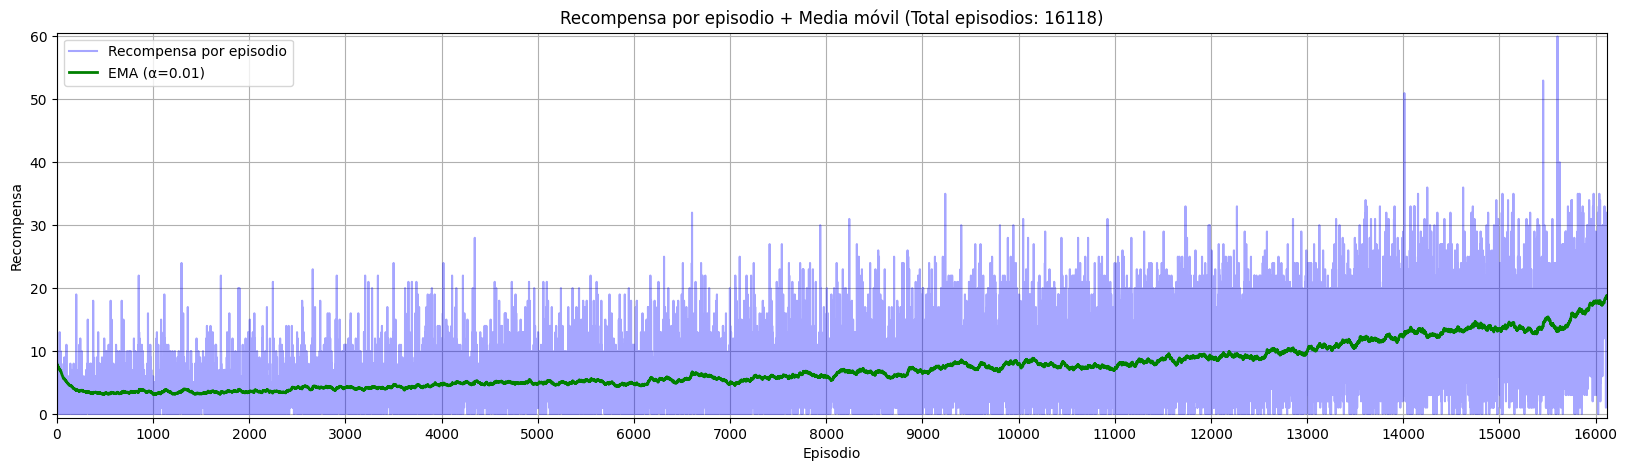

In [8]:
# Entrenamos agente.
n_tr = 1
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_1.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 28.83 | Máximo: 63.00 | Mínimo: 17.00
Objetivo no alcanzado: Se han obtenido 94 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




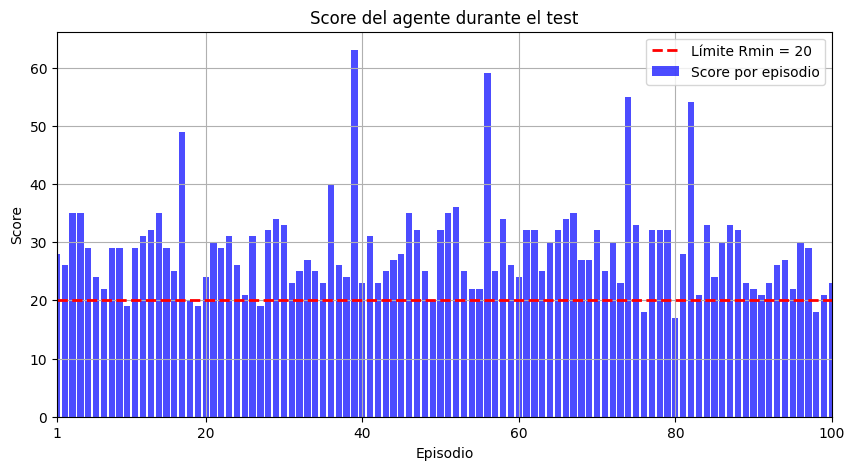

In [9]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.2.4.2 Etapa 2: Fine Tuning de 750k steps

Cargando pesos: Solucion1/dqn1_SpaceInvaders-v0_weights_final_2.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 1104s 11ms/step - reward: 19.5992
499 episodes - episode_reward: 19.599 [0.000, 36.000] - loss: 0.290 - mae: 10.627 - mean_q: 12.991 - mean_eps: 0.045
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 1988s 20ms/step - reward: 20.2639
485 episodes - episode_reward: 20.264 [0.000, 43.000] - loss: 0.256 - mae: 10.630 - mean_q: 12.973 - mean_eps: 0.039
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 1954s 20ms/step - reward: 20.5431
499 episodes - episode_reward: 20.543 [0.000, 40.000] - loss: 0.275 - mae: 10.583 - mean_q: 12.917 - mean_eps

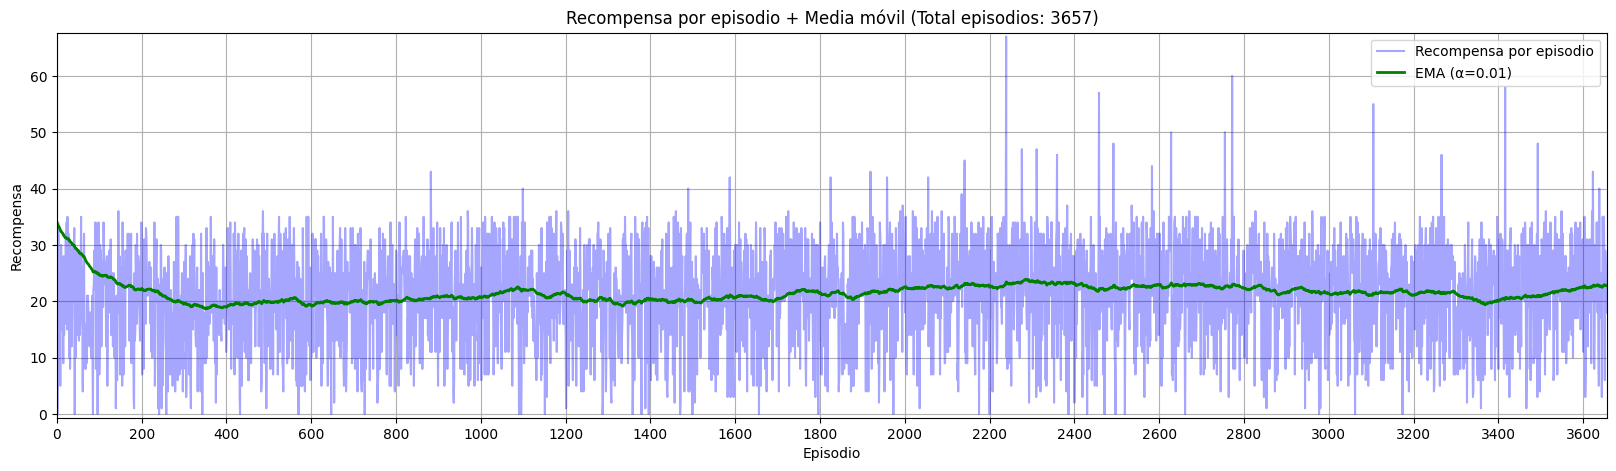

In [9]:
# Fijamos steps.
n_tr = 2
Training_Steps = 750000
decay_steps = int(Training_Steps * 0.75)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.000015
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.05,  # Continua donde lo habia dejado
    value_min=0.01,  # termina casi determinista (1% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_2.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 33.24 | Máximo: 71.00 | Mínimo: 9.00
Objetivo no alcanzado: Se han obtenido 95 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




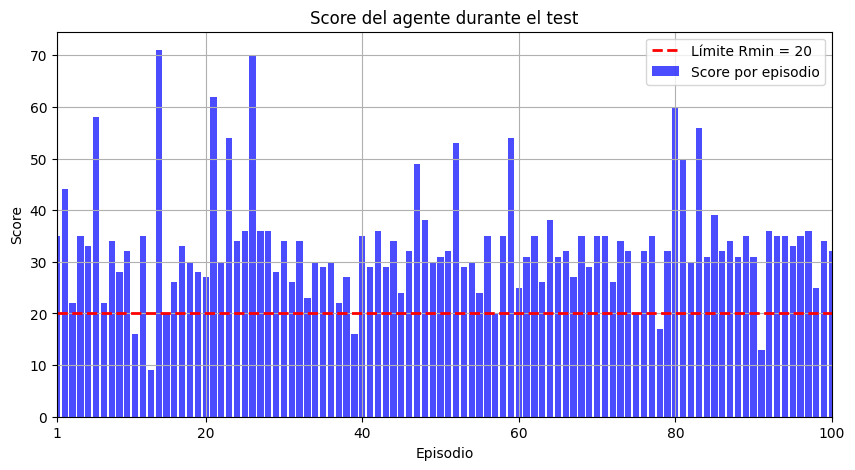

In [14]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.2.4.3 Etapa 3: Entrenamiento final de 500k steps adicionales

Cargando pesos: Solucion1/dqn1_SpaceInvaders-v0_weights_final_3.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 1077s 11ms/step - reward: 19.3509
530 episodes - episode_reward: 19.351 [0.000, 53.000] - loss: 0.210 - mae: 10.127 - mean_q: 12.294 - mean_eps: 0.082
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2015s 20ms/step - reward: 20.3505
525 episodes - episode_reward: 20.350 [0.000, 36.000] - loss: 0.231 - mae: 10.169 - mean_q: 12.364 - mean_eps: 0.065
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 1981s 20ms/step - reward: 22.4661
472 episodes - episode_reward: 22.466 [0.000, 70.000] - loss: 0.213 - mae: 10.198 - mean_q: 12.398 - mean_eps

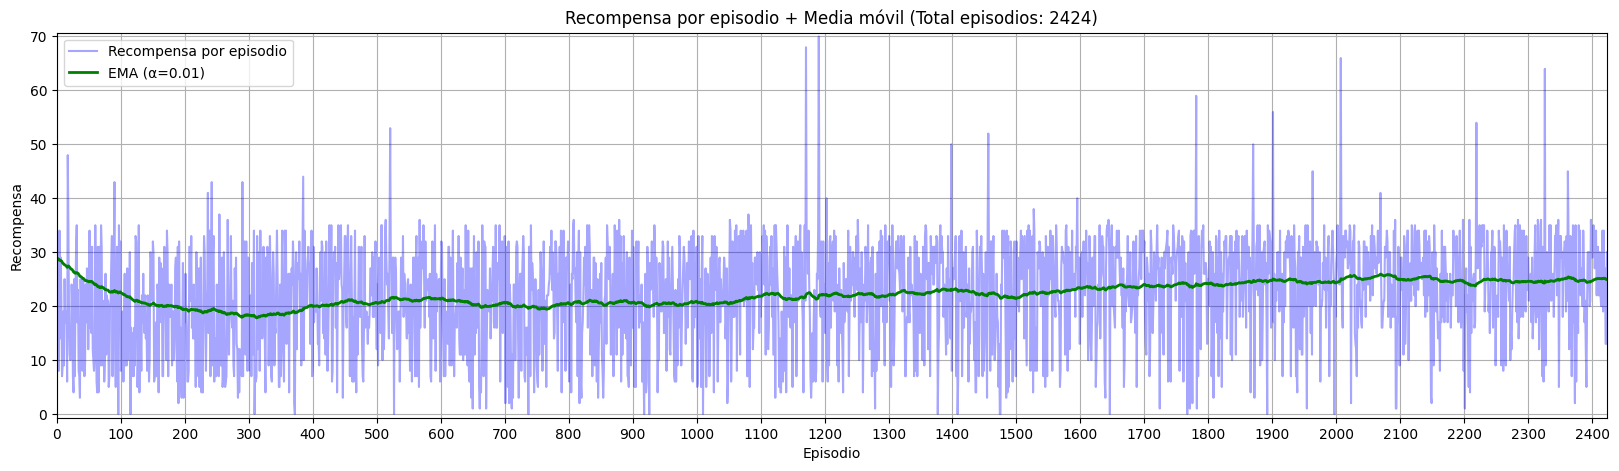

In [10]:
# Fijamos steps.
n_tr = 3
Training_Steps = 500000
decay_steps = int(Training_Steps * 0.80)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.00001
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Subimos el epsilon final de la etapa anterior para permitir exploracion de nuevo (10%) y bajamos a 0.005 con el 80% de los steps.
# El 20% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.10,  # Explora de nuevo un 10% nuevo
    value_min=0.005,  # termina casi determinista (0.5% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 36.36 | Máximo: 71.00 | Mínimo: 23.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




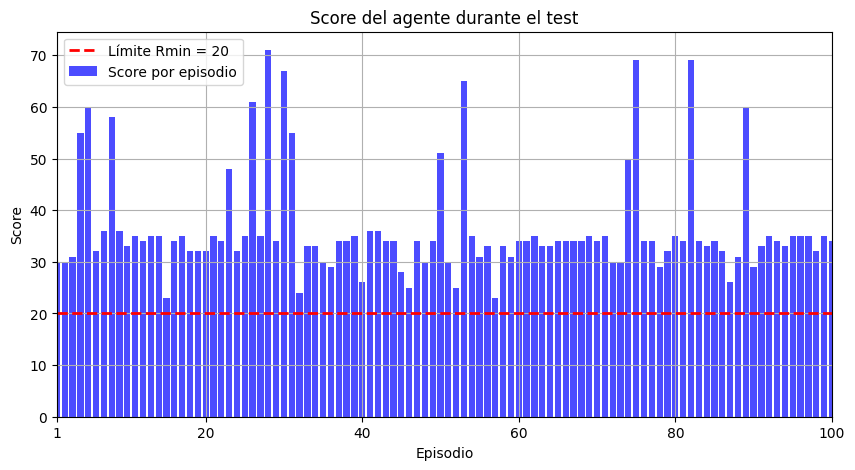

In [18]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

#### 2.2.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

---

JSON combinado guardado en: Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 22199


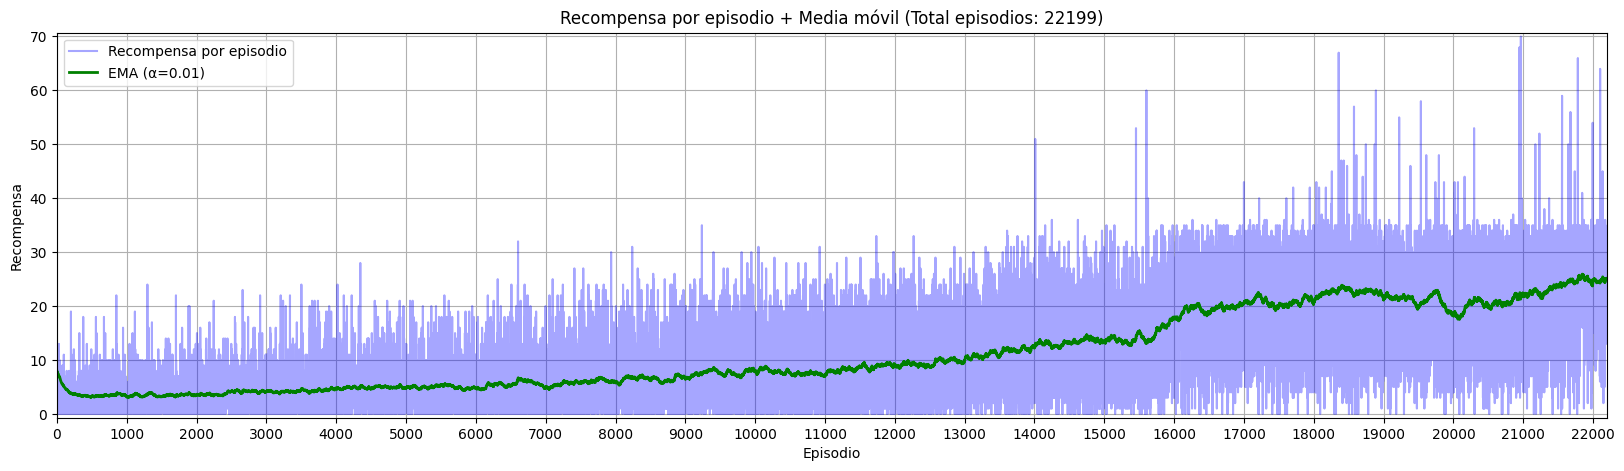

In [11]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion1/dqn1_SpaceInvaders-v0_log_1.json",
    "Solucion1/dqn1_SpaceInvaders-v0_log_2.json",
    "Solucion1/dqn1_SpaceInvaders-v0_log_3.json",
]

merge_json_logs(json_paths, "Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json", 0.01)

Cargando pesos para test: Solucion1/dqn1_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 34.17 | Máximo: 72.00 | Mínimo: 21.00
Objetivo superado: Durante 300 episodios consecutivos se ha superado o igualado los 20 puntos.




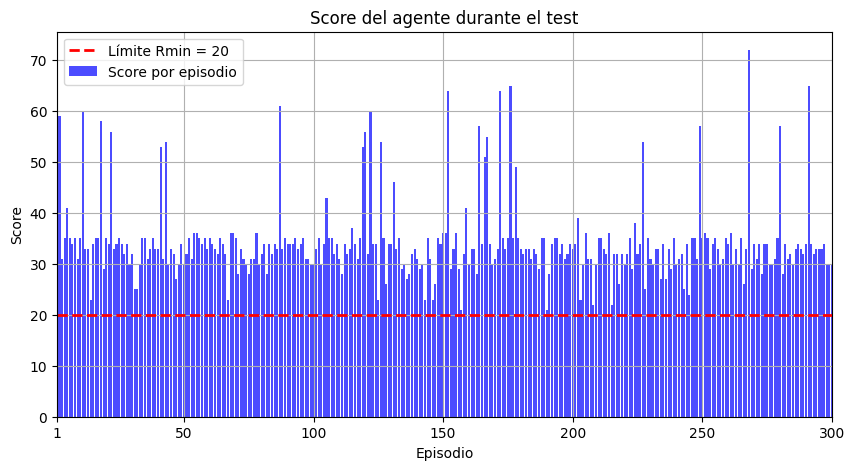

In [20]:
# Test de performance del agente durante 300 episodios
n_test = 300
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 1.5M de steps. A la vista de los resultados mostrados en la curva de entrenamiento, se identificó que el modelo mantenia una pendiente ascendente en el reward medio por lo que todavia tenia margen de mejora. Se ha utilizado un learning rate de 0.00025 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.05. La red target se actualiza cada 10k steps.
- Etapa2: Se optó por una fase de ajuste fino de 750k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 0.000015 y una estrategia E-greedy con decaimiento progresivo desde 0.05 a 0.01 para el 75% de los steps dejando el 25% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps para dar más estabilidad al aprendizaje y ayudar a que el error de los valores Q no oscile tanto.
- Etapa3: En vista a los resultados de la etapa anterior, se decide hacer una ultima etapa adicional de 500k steps. Se ha utilizado un learning rate de 0.00001 y una estrategia E-greedy con decaimiento progresivo desde 0.1 a 0.005 para el 80% de los steps dejando el 20% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps igual que en la etapa anterior.

Resultados:
- Tras 1.5M steps de entrenamiento, el test del agente ha dado un resultado de 91/100 episodios por encima de 20 puntos y una media de 27.6 puntos, lo cual no está nada mal. El aprendizaje del agente ha ido mejorando progresivamente a lo largo de los 1.5M steps.
- Tras hacer un fine tunning de 750K steps adicionales el test del agente ha dado un resultado de 95/100 episodios por encima de 20 puntos y la media ha sido de 33.2 puntos. El agente ha mejorado claramente en esta 2ª etapa.
- Finalmente tras 500k steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 36.3 puntos. El agente ha mejorado claramente en esta 3ª etapa final hasta superar el reto.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 300/300 episodios por encima de 20 puntos y la media ha sido de 34.17 puntos.
- Analizando la curva completa de entrenamiento de 2.75M de steps, vemos que el agente ha tenido un progreso claro a través de las 3 etapas desarrolladas. 


## 2.3 Solución nº2 - Double DQN
En esta solucion implementamos una arquitectura doble DQN...
<p align="center">
  <img src="img/Double_DQN_img.png" width="600">
</p>

La aproximación Double DQN surge para solucionar el problema del sesgo de sobreestimación de los valores Q. Según esta aproximación se desacoplan los procesos de selección y evaluación de una acción. Según esta aproximación se utilizará la red online (la que se esta entrenando) para seleccionar la siguiente acción y después se utilizará la target (una copia desactualizada de la online) para evaluar la acción escogida y obtener su valor Q. Con esta aproximación se evita que un error positivo accidental en una de las redes se propague de forma global. Con esto se consigue un aprendizaje mucho mas estable y una convergencia hacía una policy óptima más rápida. 

#### 2.3.1 Configuración base

In [19]:
# Definicion de parametros fijos y carga de los entornos de training & test.
# Parametros fijos
seed = 42
Memory_Size = 500000
N_Solucion = 2
Reward_min = 20
Episodios_min = 100
Training_Steps = 1500000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f"Numero de acciones del juego: {nb_actions}")
print(
    f"Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}"
)
print(f"Dimensiones del Frame del juego: [{height},{width},{channels}]")

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.3.2 Implementación de la red neuronal

In [20]:
# Definimos la arquitectura de red neuronal en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
def BuildDcnn(n_classes=6):
    model = Sequential(name="Double DQN_CNN")
    # Entrada
    model.add(Permute((2, 3, 1), input_shape=(ef.WINDOW_LENGTH,) + ef.INPUT_SHAPE))

    # Base Model - Bloque convolucional
    model.add(
        Conv2D(
            16, (8, 8), strides=(4, 4), padding="valid", activation="relu", name="conv1"
        )
    )
    model.add(
        Conv2D(
            32, (4, 4), strides=(2, 2), padding="valid", activation="relu", name="conv2"
        )
    )
    model.add(
        Conv2D(
            32, (3, 3), strides=(1, 1), padding="valid", activation="relu", name="conv3"
        )
    )

    # Top Model - Capa FC.
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation="relu", name="fc_shared"))

    # Capa final: Q(s,a)
    model.add(Dense(n_classes, activation="linear", name="Q_values"))

    return model


# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
model.summary()

Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6
Model: "Double DQN_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_2 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 9, 32)          8224      
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
fc_shared (Dense)            (None, 128)               200832    
_____________________________________________

#### 2.3.3 Implementación de la solución DQN

In [21]:
# Definimos nuestro agente: Buffer memoria, policy y tipo agente.
def BuildAgent(model, memory_size, tr_steps, n_actions, lr=0.0005):

    # Preparación de la memoria (usamos memory replay en DQN).
    ReplayBuffer = SequentialMemory(limit=memory_size, window_length=ef.WINDOW_LENGTH)

    # Llamamos a clase para pre-procesado de las observaciones.
    processor = AtariProcessor()

    # Definimos la policy, estrategia para seleccionar las acciones. Decide que accion tomar.
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),  # Estrategia E-greedy.
        attr="eps",
        value_max=1.0,  # Explora totalmente al inicio
        value_min=0.05,  # Explora poco al final del entrenamiento
        value_test=0.05,  # Exploración mínima en test
        nb_steps=tr_steps,  # Duración del decaimiento
    )

    # Definición del agente DQN. Aqui se junta todo, es el cerebro que coordina todo.
    # Llama a la ANN para estimar la Q, aplica la policy para elegir la acción, interactua con el entorno y usa el replay bufer para guardar las experiencias,
    # entrena la red mediante el target network para estabilizar el aprendizaje y la actualiza con la función de perdidas.
    dqn = DQNAgent(
        model=model,                # La red CNN que estima la distribución Q
        nb_actions=n_actions,       # Número de acciones posibles en el entorno
        memory=ReplayBuffer,        # Replay buffer para almacenar transiciones
        policy=policy,              # Política/Estrategia
        processor=processor,        # Preprocesado de observaciones
        nb_steps_warmup=20000,      # Pasos iniciales solo explorando (sin entrenar)
        target_model_update=10_000, # Copiamos los pesos de la Q online a la target cada 10_000 pasos 
        train_interval=4,           # Entrenar cada X pasos de interacción
        gamma=0.99,                 # Factor de descuento para recompensas futuras
        enable_double_dqn=True,     # Habilitamos la doble dqn
    )

    # Compilación del agente
    dqn.compile(Adam(learning_rate=lr, clipnorm=10.0), metrics=["mae"])

    # Mostrar confirmacion
    print("Agente creado con exito.")

    return dqn


# Construimos el agente.
agent = BuildAgent(model, Memory_Size, Training_Steps, nb_actions, 0.00025)

Agente creado con exito.


#### 2.3.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.3.4.1 Etapa 1: Entrenamiento desde 0 con 1.5M steps

Cargando pesos: Solucion2/dqn2_SpaceInvaders-v0_weights_final_1.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 2671s 27ms/step - reward: 3.5916
1660 episodes - episode_reward: 3.592 [0.000, 21.000] - loss: 0.035 - mae: 1.047 - mean_q: 1.301 - mean_eps: 0.962
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 3277s 33ms/step - reward: 3.8880
1634 episodes - episode_reward: 3.888 [0.000, 25.000] - loss: 0.053 - mae: 1.861 - mean_q: 2.306 - mean_eps: 0.905
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 3807s 38ms/step - reward: 4.4148
1531 episodes - episode_reward: 4.415 [0.000, 24.000] - loss: 0.079 - mae: 2.660 - mean_q: 3.280 - mean_eps: 0.842
-

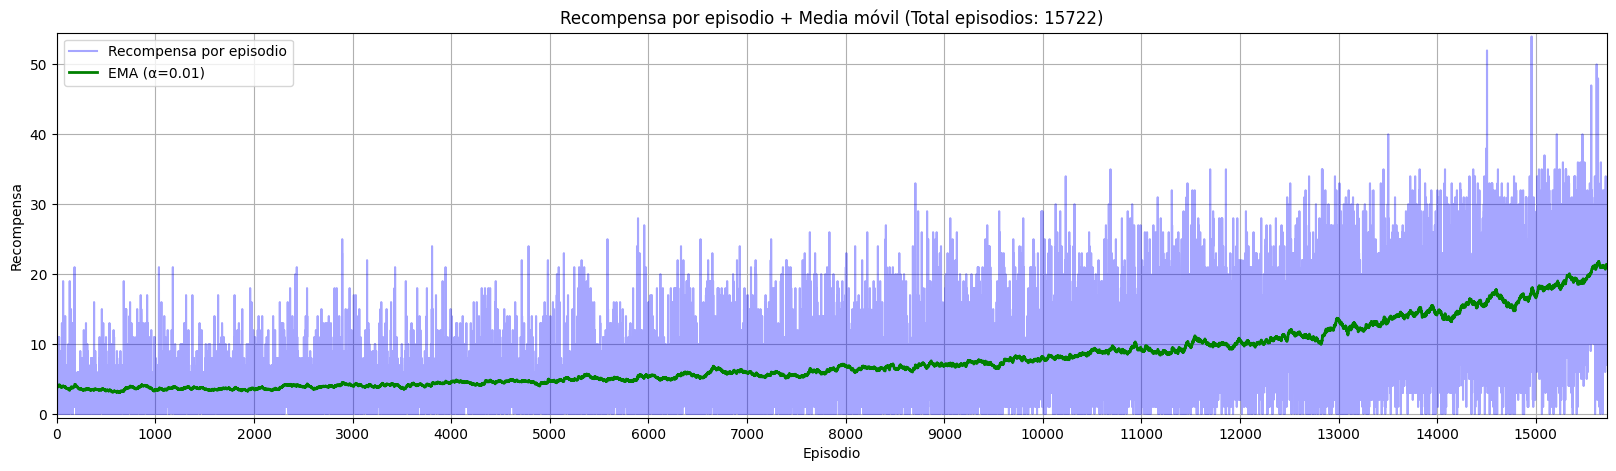

In [22]:
# Entrenamos agente.
n_tr = 1
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_1.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 31.70 | Máximo: 63.00 | Mínimo: 20.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




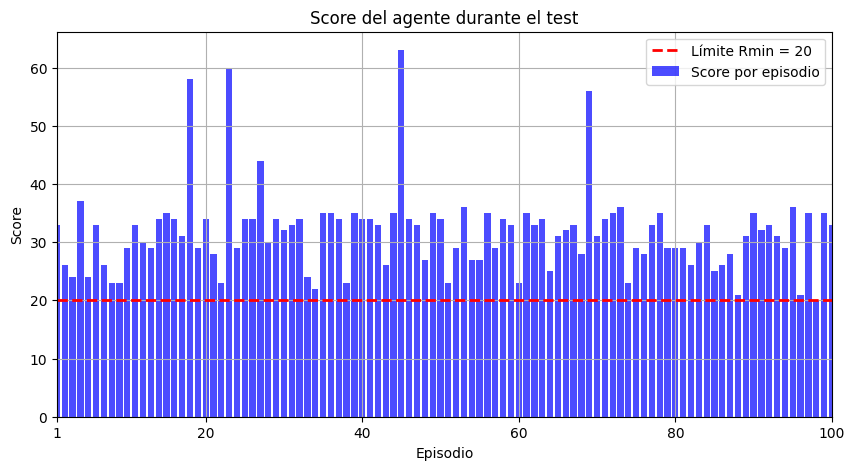

In [12]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.3.4.2 Etapa 2: Fine Tuning de 750k steps

Cargando pesos: Solucion2/dqn2_SpaceInvaders-v0_weights_final_2.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 3373s 34ms/step - reward: 20.9273
523 episodes - episode_reward: 20.927 [0.000, 69.000] - loss: 0.137 - mae: 6.984 - mean_q: 8.526 - mean_eps: 0.046
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 4022s 40ms/step - reward: 21.7861
505 episodes - episode_reward: 21.786 [0.000, 65.000] - loss: 0.132 - mae: 6.943 - mean_q: 8.473 - mean_eps: 0.039
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 4203s 42ms/step - reward: 22.2984
506 episodes - episode_reward: 22.298 [0.000, 55.000] - loss: 0.134 - mae: 6.749 - mean_q: 8.240 - mean_eps: 0.03

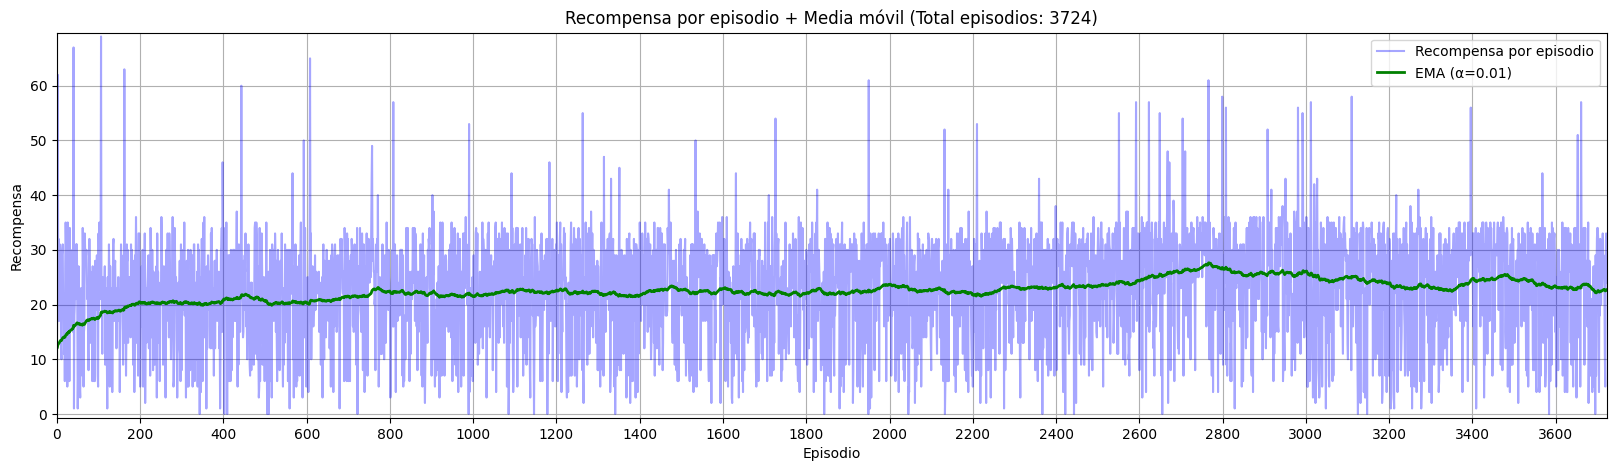

In [23]:
# Fijamos steps.
n_tr = 2
Training_Steps = 750000
decay_steps = int(Training_Steps * 0.75)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.000015
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.05,  # Continua donde lo habia dejado
    value_min=0.01,  # termina casi determinista (1% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_2.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 32.38 | Máximo: 52.00 | Mínimo: 24.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




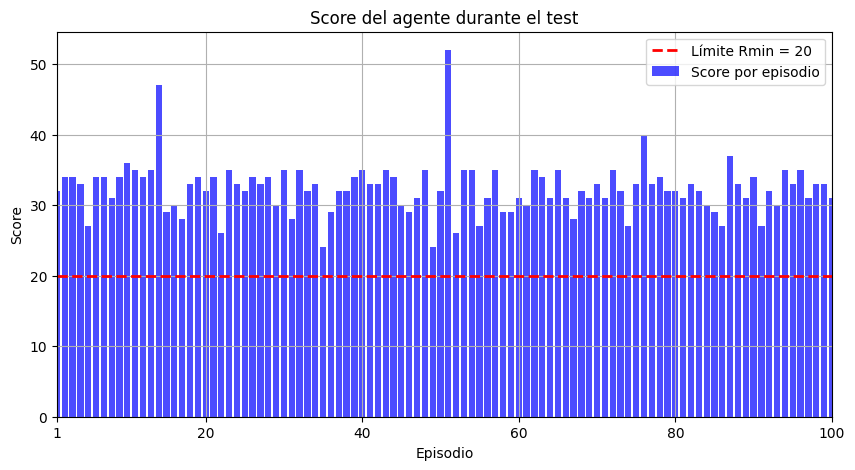

In [24]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.3.4.3 Etapa 3: Entrenamiento final de 500k steps adicionales

Cargando pesos: Solucion2/dqn2_SpaceInvaders-v0_weights_final_3.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 3396s 34ms/step - reward: 20.9674
552 episodes - episode_reward: 20.967 [0.000, 51.000] - loss: 0.131 - mae: 6.600 - mean_q: 8.044 - mean_eps: 0.086
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 4214s 42ms/step - reward: 23.5500
500 episodes - episode_reward: 23.550 [0.000, 56.000] - loss: 0.123 - mae: 6.628 - mean_q: 8.079 - mean_eps: 0.065
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 4137s 41ms/step - reward: 24.9563
480 episodes - episode_reward: 24.956 [0.000, 68.000] - loss: 0.121 - mae: 6.598 - mean_q: 8.044 - mean_eps: 0.04

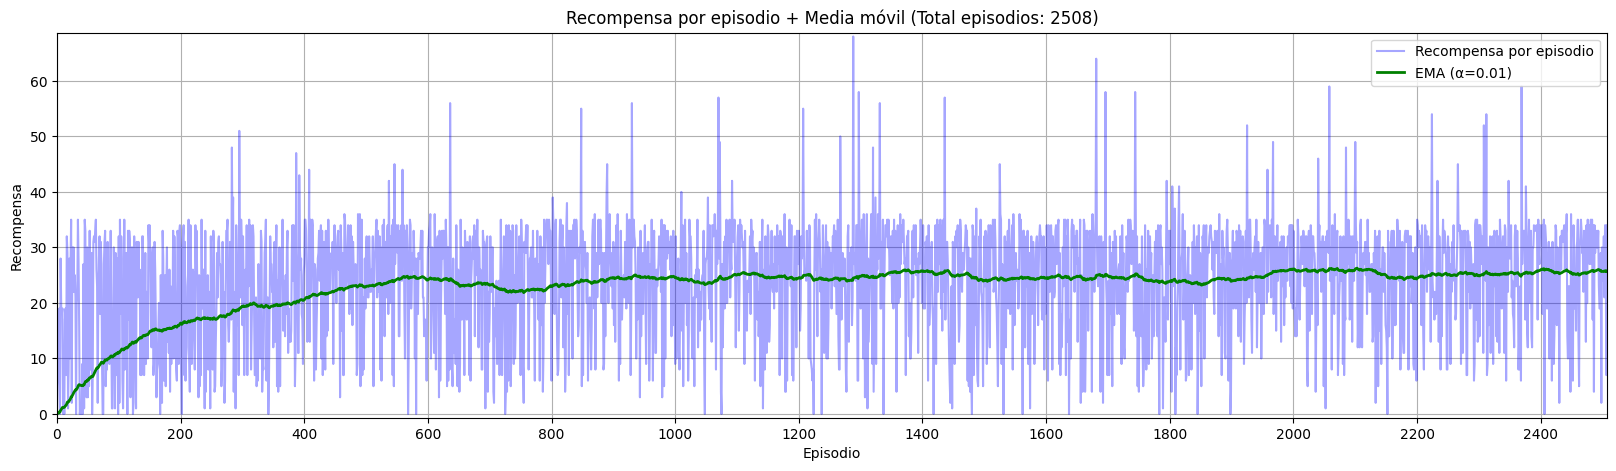

In [17]:
# Fijamos steps.
n_tr = 3
Training_Steps = 500000
decay_steps = int(Training_Steps * 0.80)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.00001
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Subimos el epsilon final de la etapa anterior para permitir exploracion de nuevo (10%) y bajamos a 0.005 con el 80% de los steps.
# El 20% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.10,  # Explora de nuevo un 10% nuevo
    value_min=0.005,  # termina casi determinista (0.5% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 34.80 | Máximo: 65.00 | Mínimo: 27.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




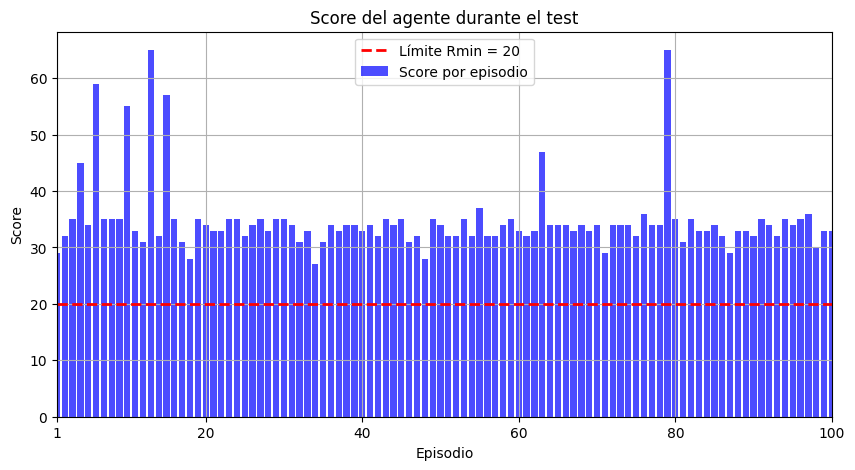

In [16]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

#### 2.3.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

---

JSON combinado guardado en: Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 21954


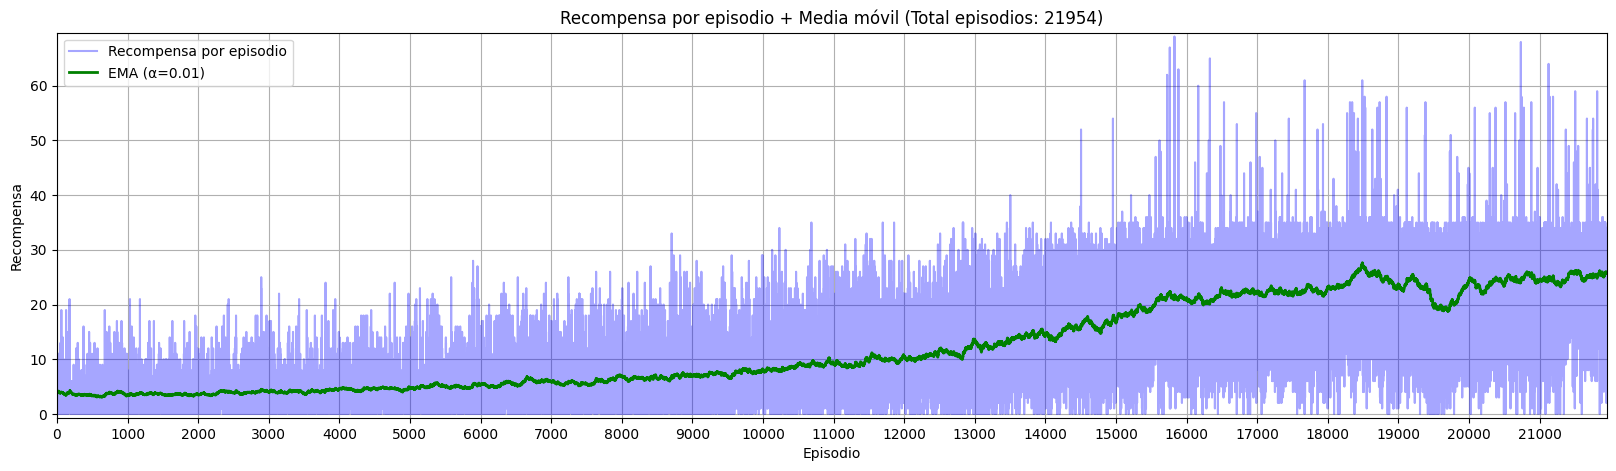

In [18]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion2/dqn2_SpaceInvaders-v0_log_1.json",
    "Solucion2/dqn2_SpaceInvaders-v0_log_2.json",
    "Solucion2/dqn2_SpaceInvaders-v0_log_3.json",
]

merge_json_logs(json_paths, "Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json", 0.01)

Cargando pesos para test: Solucion2/dqn2_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 34.71 | Máximo: 70.00 | Mínimo: 23.00
Objetivo superado: Durante 300 episodios consecutivos se ha superado o igualado los 20 puntos.




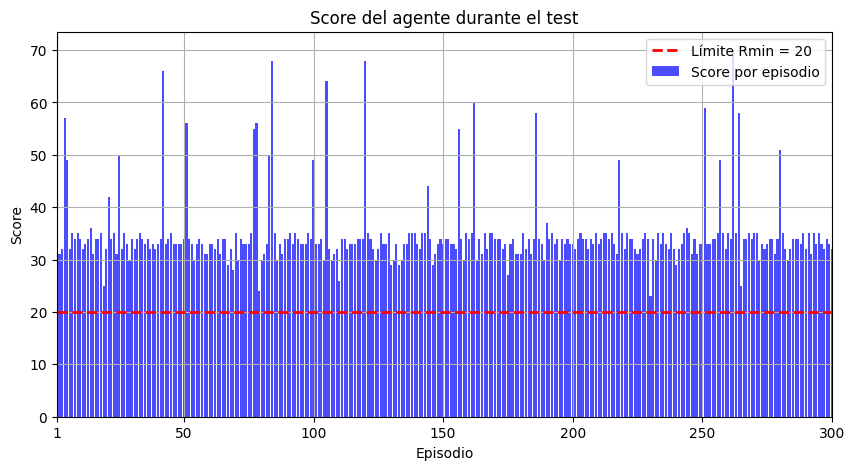

In [19]:
# Test de performance del agente durante 300 episodios
n_test = 300
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 1.5M de steps. A la vista de los resultados mostrados en la curva de entrenamiento, se identificó que el modelo mantenia una pendiente ascendente en el reward medio por lo que todavia tenia margen de mejora. Se ha utilizado un learning rate de 0.00025 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.05. La red target se actualiza cada 10k steps.
- Etapa2: Se optó por una fase de ajuste fino de 750k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 0.000015 y una estrategia E-greedy con decaimiento progresivo desde 0.05 a 0.01 para el 75% de los steps dejando el 25% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps para dar más estabilidad al aprendizaje y ayudar a que el error de los valores Q no oscile tanto.
- Etapa3: En vista a los resultados de la etapa anterior, se decide hacer una ultima etapa adicional de 500k steps. Se ha utilizado un learning rate de 0.00001 y una estrategia E-greedy con decaimiento progresivo desde 0.1 a 0.005 para el 80% de los steps dejando el 20% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 20k steps igual que en la etapa anterior.

Resultados:
- Tras 1.5M steps de entrenamiento, el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y una media de 31.7 puntos, comparado al proceso de entrenamiento de la primera solución se puede apreciar como gracias a seleccionar la siguiente accion con la red online pero evaluarla con la red target el entrenamiento es más consistente y rápido, obteniendo mejores resultados que con una simple DQN. El aprendizaje del agente ha ido mejorando progresivamente a lo largo de los 1.5M steps.
- Tras hacer un fine tunning de 750K steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 32,38 puntos. El agente no ha mejorado mucho durante esta etapa.
- Finalmente tras 500k steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 34.8 puntos. El agente ha mejorado claramente en esta 3ª etapa final aumentando bastante la media de las puntuaciones.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 300/300 episodios por encima de 20 puntos y la media ha sido de 34.71 puntos.
- Analizando la curva completa de entrenamiento de 2.75M de steps, vemos que el agente ha tenido un progreso claro a través de las 3 etapas desarrolladas. También cabe destacar que, comparando las gráficas del entrenamiento completo entre la primera y la segunda solución se ve claramente como con la segunda aproximación el entrenamiento da sus frutos mucho antes que con la primera solución.


## 2.4 Solución nº3 - Dueling Double DQN
En esta solucion implementamos una arquitectura basada en Dueling Doble DQN.

<p align="center">
  <img src="img/Schematic-Dueling-Q-Network.png" width="600">
</p>

La arquitectura Dueling Double DQN combina dos mejoras fundamentales sobre el DQN clásico con el objetivo de aumentar la estabilidad del aprendizaje y mejorar la estimación de los valores Q. Por un lado, el enfoque Dueling separa la red en dos ramas: una que estima el valor del estado (Value) y otra que estima la ventaja de cada acción (Advantage). Esta descomposición permite que la red aprenda a valorar estados incluso cuando las acciones disponibles no producen diferencias significativas en la recompensa inmediata, lo que acelera el aprendizaje en entornos con alta redundancia de acciones o recompensas escasas.

Por otro lado, la técnica Double DQN reduce la sobreestimación de los valores Q, un problema habitual en el DQN original. Para ello, utiliza la red principal para seleccionar la acción y la red target para evaluarla, desacoplando ambos procesos y obteniendo estimaciones más estables y realistas. La combinación de ambas ideas da lugar a un agente más robusto, menos propenso a sobreajustar y capaz de aprender políticas más precisas en entornos complejos como los juegos Atari.

#### 2.4.1 Configuración base

In [25]:
# Parametros fijos
seed = 42
Memory_Size = 1000000
N_Solucion = 3
Reward_min = 20
Episodios_min = 100
Training_Steps = 900000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f"Numero de acciones del juego: {nb_actions}")
print(
    f"Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}"
)
print(f"Dimensiones del Frame del juego: [{height},{width},{channels}]")

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.4.2 Implementación de la red neuronal

In [26]:
# Definimos la arquitectura de red en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
# DQN
def BuildDcnn(n_classes=6):
    model = Sequential()
    # Entrada
    model.add(Permute((2, 3, 1), input_shape=(ef.WINDOW_LENGTH,) + ef.INPUT_SHAPE))

    # Base Model - Bloque convolucional
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation="relu"))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation="relu"))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu"))

    # Top Model - Capa FC.
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))

    # Capa final: Q(s,a)
    model.add(Dense(n_classes, activation="linear"))

    return model


# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
model.summary()

Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________

#### 2.4.3 Implementación de la solución DQN

In [27]:
# Definimos nuestro agente: Buffer memoria, policy y tipo agente.
def BuildAgent(model, memory_size, tr_steps, n_actions, lr=0.0005):

    # Preparación de la memoria (usamos memory replay en DQN).
    ReplayBuffer = SequentialMemory(limit=memory_size, window_length=ef.WINDOW_LENGTH)

    # Llamamos a clase para pre-procesado de las observaciones.
    processor = AtariProcessor()

    # Definimos la policy, estrategia para seleccionar las acciones. Decide que accion tomar.
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),  # Estrategia E-greedy.
        attr="eps",
        value_max=1.0,  # Explora totalmente al inicio
        value_min=0.1,  # Explora poco al final del entrenamiento
        value_test=0.001,  # Exploración mínima en test
        nb_steps=tr_steps,  # Duración del decaimiento
    )

    # Definición del agente DQN. Aqui se junta todo, es el cerebro que coordina todo.
    # Llama a la ANN para estimar la Q, aplica la policy para elegir la acción, interactua con el entorno y usa el replay bufer para guardar las experiencias,
    # entrena la red mediante el target network para estabilizar el aprendizaje y la actualiza con la función de perdidas.
    dqn = DQNAgent(
        model=model,  # La red CNN que estima la distribución Q
        nb_actions=n_actions,  # Número de acciones posibles en el entorno
        memory=ReplayBuffer,  # Replay buffer para almacenar transiciones
        policy=policy,  # Política/Estrategia
        processor=processor,  # Preprocesado de observaciones
        nb_steps_warmup=100000,  # Pasos iniciales solo explorando (sin entrenar)
        target_model_update=5e-3,  # Frecuencia de actualización del target network (=5e-3 activamos soft update)
        train_interval=4,  # Entrenar cada X pasos de interacción
        gamma=0.99,  # Factor de descuento para recompensas futuras
        batch_size=32,  # Tamaño de batch
        enable_double_dqn=True,  # Activar double dqn
        enable_dueling_network=True,  # Activar dueling netowrk
        dueling_type="avg",  # Tipo de dueling
        delta_clip=1.0,  # Delta clip
    )

    # Compilación del agente
    dqn.compile(Adam(learning_rate=lr, clipnorm=10.0), metrics=["mae"])

    # Mostrar confirmacion
    print("Agente creado con exito.")

    return dqn


# Construimos el agente.
agent = BuildAgent(model, Memory_Size, Training_Steps, nb_actions, 1e-4)

Agente creado con exito.


#### 2.4.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.4.4.1 Etapa 1: Entrenamiento desde 0 con 0.9M steps

Cargando pesos: Solucion3/dqn3_SpaceInvaders-v0_weights_final_1.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 497s 5ms/step - reward: 3.8449
1599 episodes - episode_reward: 3.845 [0.000, 29.000] - loss: 0.000 - mae: 0.000 - mean_q: 0.000 - mean_eps: 0.000
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2976s 30ms/step - reward: 3.8783
1586 episodes - episode_reward: 3.878 [0.000, 24.000] - loss: 0.094 - mae: 2.950 - mean_q: 3.535 - mean_eps: 0.866
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 3284s 33ms/step - reward: 4.4394
1509 episodes - episode_reward: 4.439 [0.000, 24.000] - loss: 0.197 - mae: 6.759 - mean_q: 8.116 - mean_eps: 0.776
---

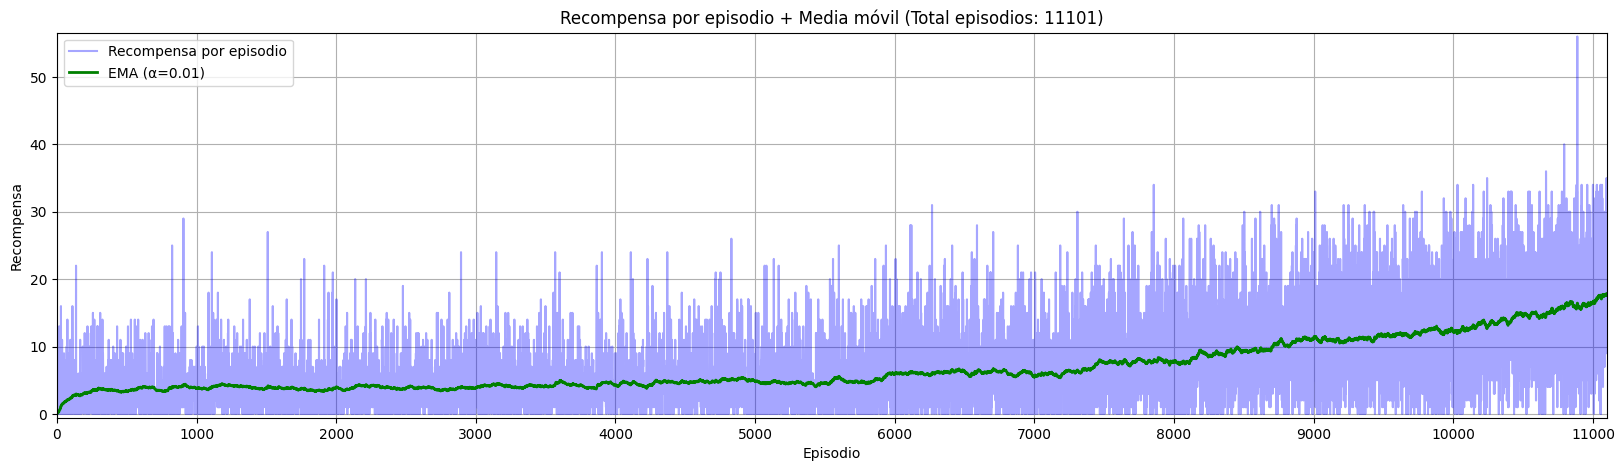

In [28]:
# Entrenamos agente.
n_tr = 1
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_1.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 22.18 | Máximo: 34.00 | Mínimo: 10.00
Objetivo no alcanzado: Se han obtenido 69 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




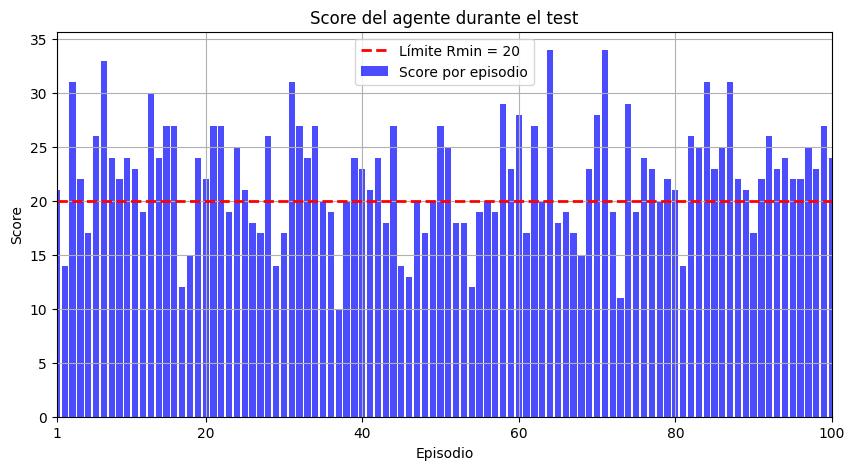

In [31]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.4.4.2 Etapa 2: Fine Tuning de 600k steps

Cargando pesos: Solucion3/dqn3_SpaceInvaders-v0_weights_final_2.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 2238s 22ms/step - reward: 15.5520
712 episodes - episode_reward: 15.552 [0.000, 57.000] - loss: 0.123 - mae: 9.979 - mean_q: 12.077 - mean_eps: 0.178
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2777s 28ms/step - reward: 17.0318
724 episodes - episode_reward: 17.032 [0.000, 44.000] - loss: 0.125 - mae: 10.264 - mean_q: 12.426 - mean_eps: 0.146
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 3083s 31ms/step - reward: 18.4023
696 episodes - episode_reward: 18.402 [0.000, 41.000] - loss: 0.121 - mae: 10.245 - mean_q: 12.399 - mean_eps:

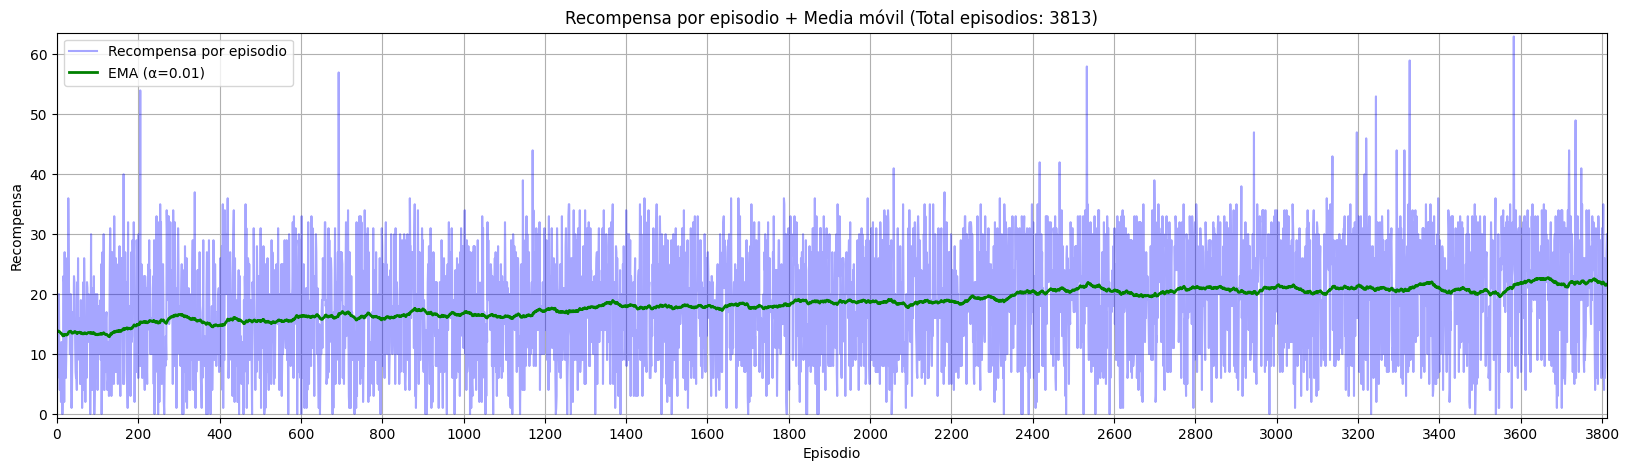

In [33]:
# Fijamos steps.
n_tr = 2
Training_Steps = 600000
decay_steps = 500000

# Reducimos learning rate para fine‑tuning
LearningRate = 1e-4
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.10,  # Continua donde lo habia dejado
    value_min=0.02,  # termina casi determinista (2% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=decay_steps,
)

# Reducimos el numero de steps de exploracion inicial.
agent.nb_steps_warmup = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_2.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 32.21 | Máximo: 66.00 | Mínimo: 11.00
Objetivo no alcanzado: Se han obtenido 98 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




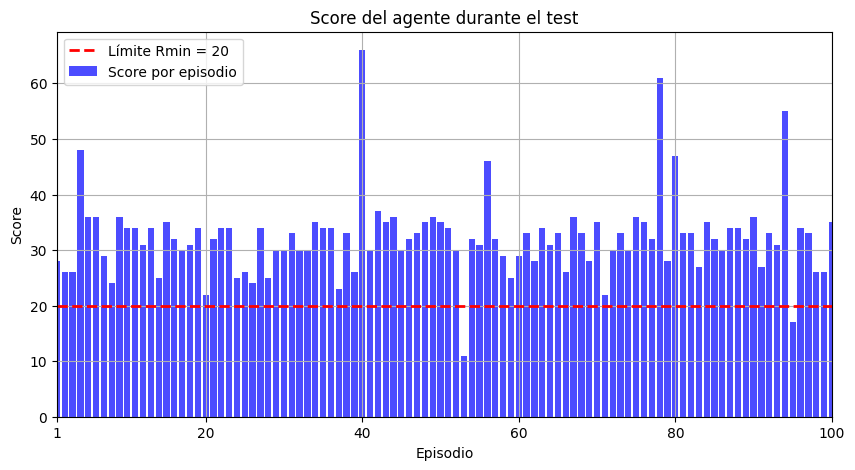

In [30]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

##### 2.4.4.3 Etapa 3: Fine Tuning de 300k steps

Cargando pesos: Solucion3/dqn3_SpaceInvaders-v0_weights_final_3.h5f
Mostramos los datos del entrenamiento realizado:

Interval 1 (100000 steps performed)
100000/100000 [==============================] - 2080s 21ms/step - reward: 26.1796
540 episodes - episode_reward: 26.180 [0.000, 71.000] - loss: 0.069 - mae: 8.665 - mean_q: 10.510 - mean_eps: 0.017
------------------------------------------------------------------------------------------
Interval 2 (200000 steps performed)
100000/100000 [==============================] - 2540s 25ms/step - reward: 26.7761
527 episodes - episode_reward: 26.776 [3.000, 60.000] - loss: 0.062 - mae: 8.299 - mean_q: 10.091 - mean_eps: 0.012
------------------------------------------------------------------------------------------
Interval 3 (300000 steps performed)
100000/100000 [==============================] - 2777s 28ms/step - reward: 26.8692
543 episodes - episode_reward: 26.869 [1.000, 65.000] - loss: 0.062 - mae: 8.302 - mean_q: 10.101 - mean_eps: 0

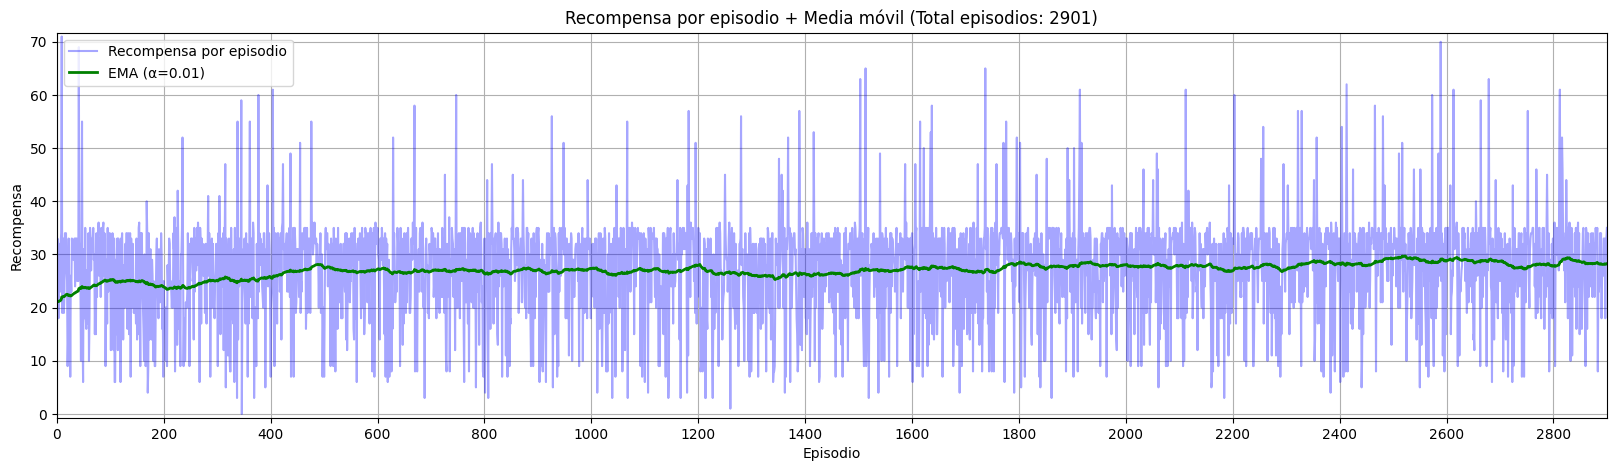

In [34]:
# Fijamos steps.
n_tr = 3
Training_Steps = 300000

# Reducimos learning rate para fine‑tuning
LearningRate = 5e-5
K.set_value(agent.model.optimizer.learning_rate, LearningRate)

# Actualizamos estrategia agente
# Continuamos con el epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=0.02,  # Continua donde lo habia dejado
    value_min=0.01,  # termina casi determinista (2% aleatorio)
    value_test=0.0,  # test sin azar
    nb_steps=Training_Steps,
)

# Reducimos el numero de steps de exploracion inicial.
agent.nb_steps_warmup = 20000

# Entrenamos agente.
TrainAgent(agent, env_tr, Training_Steps, N_Solucion, n_train=n_tr)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 38.78 | Máximo: 71.00 | Mínimo: 26.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




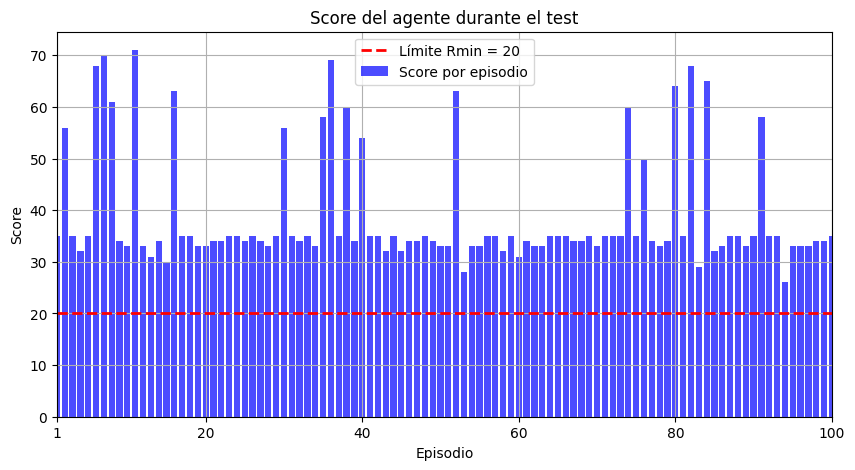

In [32]:
# Test de performance del agente
n_test = 100
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

#### 2.4.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

JSON combinado guardado en: Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 17815


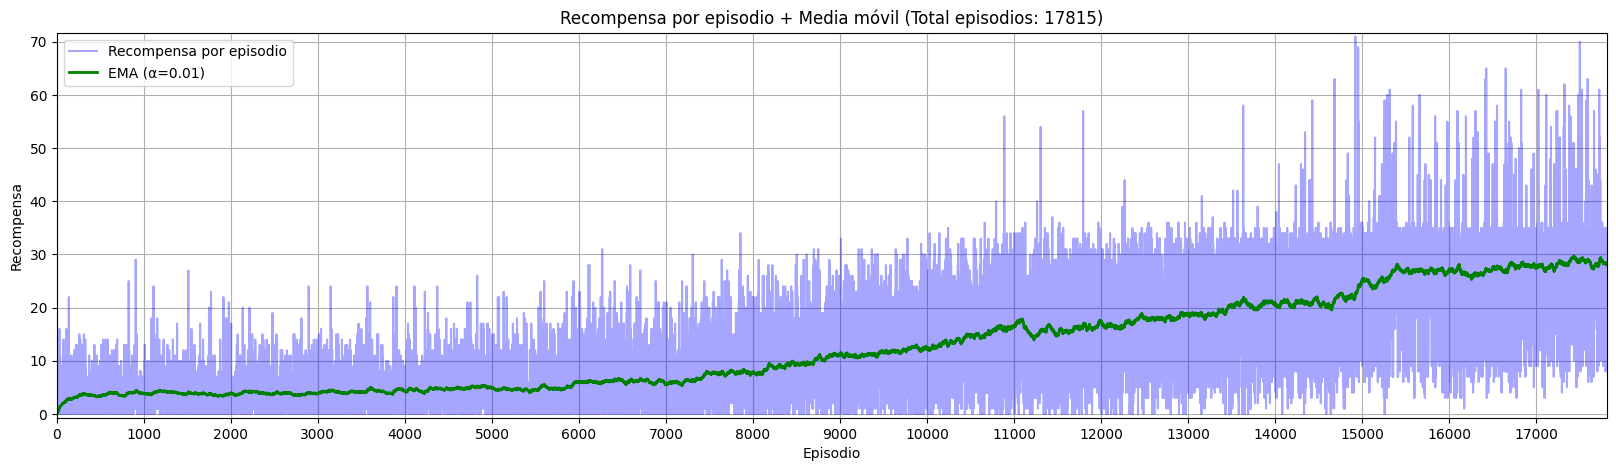

In [35]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion3/dqn3_SpaceInvaders-v0_log_1.json",
    "Solucion3/dqn3_SpaceInvaders-v0_log_2.json",
    "Solucion3/dqn3_SpaceInvaders-v0_log_3.json",
]

merge_json_logs(json_paths, "Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json", 0.01)

Cargando pesos para test: Solucion3/dqn3_SpaceInvaders-v0_weights_final_3.h5f
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 39.13 | Máximo: 93.00 | Mínimo: 25.00
Objetivo superado: Durante 300 episodios consecutivos se ha superado o igualado los 20 puntos.




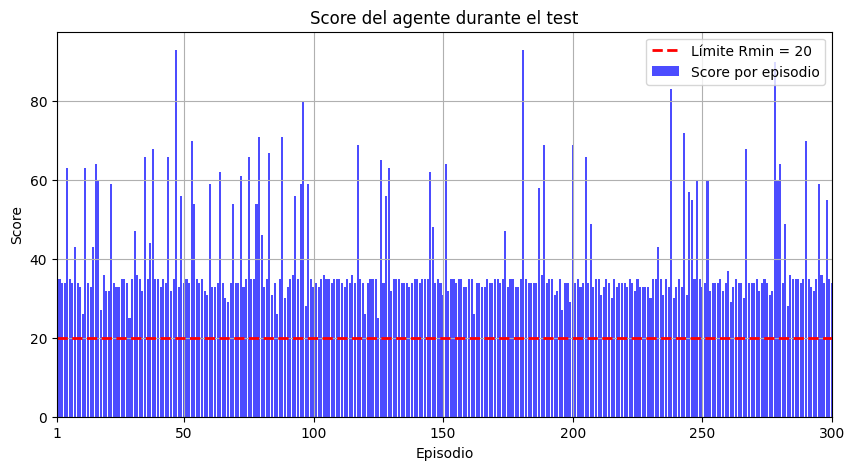

In [34]:
# Test de performance del agente durante 300 episodios
n_test = 300
TestAgent(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)

---

Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 0.9M de steps. A la vista de los resultados mostrados en la curva de entrenamiento, se identificó que el modelo mantenia una pendiente ascendente en el reward medio por lo que todavia tenia margen de mejora. Se ha utilizado un learning rate de 1e-4 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.1.
- Etapa2: Se optó por una fase de ajuste fino de 600k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 1e-4 y una estrategia E-greedy con decaimiento progresivo desde 0.1 a 0.02 para 500k steps dejando los ultimos 100k steps con epsilon fijo para hacer entrenamiento mas determinista.
- Etapa3: En vista a los resultados de la etapa anterior, se decide hacer una ultima etapa adicional de 300k steps. Se ha utilizado un learning rate de 5e-5 y una estrategia E-greedy con decaimiento progresivo desde 0.02 a 0.01 para hacer el entrenamiento mas determinista.

Resultados:
- Tras 0.9M steps de entrenamiento, el test del agente ha dado un resultado de 69/100 episodios por encima de 20 puntos y una media de 22.18 puntos, lo cual no está nada mal. El aprendizaje del agente ha ido mejorando progresivamente a lo largo de los 0.9M steps.
- Tras hacer un fine tunning de 600K steps adicionales el test del agente ha dado un resultado de 98/100 episodios por encima de 20 puntos y la media ha sido de 32.2 puntos. El agente ha mejorado claramente en esta 2ª etapa.
- Finalmente tras 300k steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 38.7 puntos. El agente ha mejorado claramente en esta 3ª etapa final hasta superar el reto.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 300/300 episodios por encima de 20 puntos y la media ha sido de 39.1 puntos.
- El performance de este agente es superior al obtenido en el experimento 1 (agente DQN) pero con 1M de steps menos de entrenamiento, lo que confirma la eficiencia de esta solución. 
- Analizando la curva completa de entrenamiento de 1.8M de steps, vemos que el agente ha tenido un progreso claro a través de las 3 etapas desarrolladas y aún no se observa estancamiento. Se podria seguir entrenando más.


## 2.5 Solución nº4 - DQN + PER en PyTorch
En esta solucion implementamos una arquitectura basada en la arquitectura DQN + Prioritized Experience Reaplay.
<p align="center">
  <img src="img/Single_DQN_img.png" width="600">
</p>

La red DQN-PER es una extensión del Experience replay clásico que asigna una probabilidad de muestreo mayor a aquellas transiciones que generan un error TD elevado. Para ello PER introduce dos mecanismos clave:
 - Prioridades basadas en el TD‑error.
 - Pesos de importancia (IS weights) para corregir el sesgo introducido por el muestreo no uniforme.

Al combinar PER con DQN se acelera el aprendizaje, se mejora la estabilidad y se reduce el número de episodios necesarios para alcanzar un rendimiento competitivo.


#### 2.5.1 Configuración base

In [5]:
# Definicion de parametros fijos y carga de los entornos de training & test.
# Parametros fijos
seed = 42
Memory_Size = 350000
N_Solucion = 4
Reward_min = 20
Episodios_min = 100
Training_Steps = 1800000

# Definimos la semilla para la reproducibilidad de la ejecución
set_seeds(seed)
torch.manual_seed(seed) # Reproducibilidad

# Cargamos entornos de simulacion
env_tr = make_env(seed, training=True)
env_te = make_env(seed, training=False)

# Extraemos informacion sobre las acciones y el espacio de observacion del entorno
nb_actions = env_tr.action_space.n
height, width, channels = env_tr.observation_space.shape

print(f'Numero de acciones del juego: {nb_actions}')
print(f'Tipo de acciones disponibles en el juego: {env_tr.unwrapped.get_action_meanings()}')
print(f'Dimensiones del Frame del juego: [{height},{width},{channels}]')

Numero de acciones del juego: 6
Tipo de acciones disponibles en el juego: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Dimensiones del Frame del juego: [210,160,3]


#### 2.5.2 Implementación de la red neuronal

In [5]:
# Definimos la arquitectura de red neuronal en una funcion, asi podemos llamarla directamente y pasarle los parametros que vamos a evaluar.
class BuildDcnn(torch.nn.Module):
  def __init__(self, n_classes=6):
    super(BuildDcnn, self).__init__()
    
    C, H, W = ef.WINDOW_LENGTH, ef.INPUT_SHAPE[0], ef.INPUT_SHAPE[1]
      
    # Definimos las capas de la red neuronal
    # 1) Base Model
    self.conv1 = torch.nn.Conv2d(C, 16, 8, stride=4)
    self.conv2 = torch.nn.Conv2d(16, 32, 4, stride=2)
    self.conv3 = torch.nn.Conv2d(32, 32, 3, stride=1)

    # --- Cálculo automático del tamaño del flatten --- 
    with torch.no_grad(): 
        dummy = torch.zeros(1, C, H, W) 
        out = self.conv3(self.conv2(self.conv1(dummy))) 
        self.flatten_size = out.numel()
      
    # 2) Proyección intermedia (Asumimos que hemos hecho flatten)
    self.fc1 = torch.nn.Linear(self.flatten_size, 128)

    # 3) Salida
    self.fc2 = torch.nn.Linear(128, n_classes) # number of actions

  def forward(self, x):

    # 1) Forward base model
    x = torch.nn.functional.relu(self.conv1(x))
    x = torch.nn.functional.relu(self.conv2(x))
    x = torch.nn.functional.relu(self.conv3(x))

    # 2) Flatten + Projection
    x = x.view(x.size(0), -1)
    x = torch.nn.functional.relu(self.fc1(x))

    # 3) Salida hibrida
    x = self.fc2(x) # Salida linea (Q-values)

    return x

# mostramos datos entrada
print("Tamaño de la imagen de entrada:", ef.IM_SHAPE)
print("Numero de clases/acciones:", nb_actions)

# Llamamos a la funcion de construccion de la red del modelo. Esta red neuronal: recibe el estado s, produce vector con los valores Q(s,a), en este caso
# tendremos un vector con 6 componentes (6 acciones). La red evalua cual es la mejor Q(s,a).
current_model = BuildDcnn(nb_actions)

# Mostramos la arquitectura de la red declarada
summary(current_model, input_size=(1, ef.WINDOW_LENGTH, ef.INPUT_SHAPE[0], ef.INPUT_SHAPE[1]))


Tamaño de la imagen de entrada: (84, 84, 4)
Numero de clases/acciones: 6


Layer (type:depth-idx)                   Output Shape              Param #
BuildDcnn                                [1, 6]                    --
├─Conv2d: 1-1                            [1, 16, 20, 20]           4,112
├─Conv2d: 1-2                            [1, 32, 9, 9]             8,224
├─Conv2d: 1-3                            [1, 32, 7, 7]             9,248
├─Linear: 1-4                            [1, 128]                  200,832
├─Linear: 1-5                            [1, 6]                    774
Total params: 223,190
Trainable params: 223,190
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.11
Forward/backward pass size (MB): 0.09
Params size (MB): 0.89
Estimated Total Size (MB): 1.09

#### 2.5.3 Implementación de la solución DQN

In [6]:
# Definimos nuestro agente: Device, buffer memoria, optimizador y policy.
# # Seleccionar device CPU/GPU
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Preparación de la memoria (usamos memory replay en DQN).
replay_buffer = ReplayBufferPER(Memory_Size)

# Llamamos al optimizador
optimizer = optim.Adam(current_model.parameters(), lr=0.00025)

# Llamamos al agente
agent = DQNag(
    c_model= current_model,              # Modelo red CNN actual que estima la distribución Q
    n_actions= nb_actions,               # Número de acciones posibles en el entorno
    env= env_tr,                         # Entorno de simulación
    eps_start= 1.0,                      # Epsilon inicial
    eps_final= 0.05,                     # Epsilon final
    eps_decay= Training_Steps,           # Duración del decaimiento
    exp_decay= False,                    # = True activa epsilon exponencial, sino es lineal.
    nb_steps_warmup=50000,               # Pasos iniciales solo explorando (sin entrenar)     
    train_interval=4,                    # Entrenar y calcular TD cada X pasos de interacción
    target_model_update=10000,           # Frecuencia de actualización del target network
    batch_size=32,                       # Tamaño de batch
    gamma=0.99,                          # Factor de descuento para recompensas futuras
    soft_update=False,                   # Activar soft update del target.
    tau=0.005)                           # Parametro soft update

# Mostrar confirmacion
print("Agente creado con exito.")


Agente creado con exito.


#### 2.5.4 Entrenamiento del Agente DQN
Configuramos y ejecutamos el entrenamiento del agente. Se realiza un entrenamiento en 3 etapas, con diferente numero de steps e hiperparametros del agente en cada una de ellas. Al final de este a apartado se analizan los resultados.

##### 2.5.4.1 Etapa 1: Entrenamiento desde 0 con 1.2M steps

In [7]:
# Funcion training agente DQN PyTorch  
def TrainDQNtorch(agent, replay_buffer, optimizer, tr_steps, model_class, n_sol=1, n_train=1):
    # Crear carpeta de la solución
    folder = Path(f"Solucion{n_sol}") 
    folder.mkdir(exist_ok=True)
    
    # Ficheros finales
    env_name = ef.ENV_NAME
    w_filename = folder / f'dqn{n_sol}_{env_name}_weights_final_{n_train}.pth'
    log_filename = folder / f'dqn{n_sol}_{env_name}_log_{n_train}.json'
    
    # Llamamos a clase gestion de logs
    logger = LogTorch(interval=100000, tr_steps=tr_steps)

    # Si existe fichero de datos anterior simplemente cargamos los datos y salimos de la funcion.
    loaded = logger.load_log(log_filename)
    if loaded:
        plot_rewards(log_filename, 0.01)
        return
    
    # Si no hay fichero previo --> Ejecutamos proceso entrenamiento. 
    # Inicializamos variables
    td_data = 0,0,0
    HEIGHT, WIDTH = ef.INPUT_SHAPE
    N_FRAMES = ef.WINDOW_LENGTH
    beta = 0.4
    beta_increment = (1-beta)/tr_steps
    
    # Intanciamos el modelo del agente
    current_model = agent.c_model
    
    # Creamos target model y lo actualizamos con los mismos pesos
    target_model = model_class(agent.n_actions)
    update_target(current_model, target_model, agent.tau, agent.soft_update)
    target_model.eval()
    current_model.train()

    # Carga de entorno e incializacion del estado.
    env= agent.env
    obs = env.reset()
    state = update_frame_sequence(state=None, obs=obs, n_frames=N_FRAMES, width=WIDTH, height=HEIGHT)
    
    # Bucle principal ejecucion de steps.
    for n_step in range(1, tr_steps + 1):

        #------------------- PROCESO PRINCIPAL --------------------------
        # 1.Calculamos accion con el agente
        action = agent.act(state, n_step)

        # 2.Ejecutamos accion en el entorno y obtenemos observación
        obs, reward, done, _ = env.step(action)
        
        # Hacemos clipping del reward 
        reward = max(-1, min(1, reward))

        # 3.Actualizamos estado y recompensa
        next_state = update_frame_sequence(state=state, obs=obs, n_frames=N_FRAMES, width=WIDTH, height=HEIGHT)

        # 4.Guardamos en buffer transicción sarsd
        replay_buffer.push(state, action, reward, next_state, done)

        # 5. Actualizar estado 
        state = next_state

        # 6.Episodio completado -> reseteamos y salvamos reward por episodio
        if done:
            obs = env.reset()
            state = update_frame_sequence(state=None, obs=obs, n_frames=N_FRAMES, width=WIDTH, height=HEIGHT)
    
        # 7.Ejecutamos actualizacion pesos modelo principal mediante TD.
        # evento disparo TD. Si el número de observaciones > steps calentamiento & cada X steps 
        calcula_TD = (len(replay_buffer) > agent.nb_steps_warmup) and (n_step % agent.train_interval == 0) 

        # Si hay evento disparo calculo TD
        if calcula_TD:                       
            current_model.train()            # aseguramos modo entrenamiento 

            td_data = compute_td_loss_PER(       # calculamos TD loss
                c_model=current_model,
                t_model=target_model,
                optimizer=optimizer,
                replay_buffer=replay_buffer,
                device=agent.device,
                batch_size=agent.batch_size,
                gamma=agent.gamma,
                beta= beta,
                clipnorm =  10,                 # = 0 no se usa. 
                huberloss = True                # True: huber loss/ False: MSE
            )
            
            # Actualizamos valor de beta
            beta = max(min(1.0, beta + beta_increment), 0.3)

                
        # 8.Actualizamos red target cada n_steps = update_step
        actualiza_target = (
            (n_step % agent.target_model_update == 0 and not agent.soft_update) 
            or (agent.soft_update and calcula_TD)
        )
        
        if actualiza_target:
            update_target(current_model, target_model, agent.tau, agent.soft_update)

        # 9.Print informacion progreso intervalo actual
        logger.update_interval(n_step, td_data, done, reward, agent.epsilon) 

        
    # 10.Salvamos fichero logs
    logger.save_log(log_filename)

    # 11.Salvamos pesos modelo
    torch.save(current_model.state_dict(), w_filename)

    # 12.Ponemos el modelo de nuevo en eval.
    current_model.eval()

    # 13.Mostramos plot de resultados.
    plot_rewards(log_filename, 0.01)
    

Fichero Logs 'Solucion4/dqn4_SpaceInvaders-v0_log_1.json' cargado correctamente.

Interval 1 (100000 steps performed)
100000/100000 [====================] - 277s 2.8ms/step - reward: 0.0587
1660 episodes - episode_reward: 3.538 [0.000, 20.000] - loss: 0.013 - mae: 0.129 - mean_q: 0.283 - mean_eps: 0.974
------------------------------------------------------------------------------------------
Interval 2 (100000 steps performed)
100000/100000 [====================] - 489s 4.9ms/step - reward: 0.0618
1662 episodes - episode_reward: 3.718 [0.000, 21.000] - loss: 0.038 - mae: 0.321 - mean_q: 1.740 - mean_eps: 0.921
------------------------------------------------------------------------------------------
Interval 3 (100000 steps performed)
100000/100000 [====================] - 546s 5.5ms/step - reward: 0.0638
1519 episodes - episode_reward: 4.199 [0.000, 25.000] - loss: 0.069 - mae: 0.445 - mean_q: 3.370 - mean_eps: 0.868
-------------------------------------------------------------------

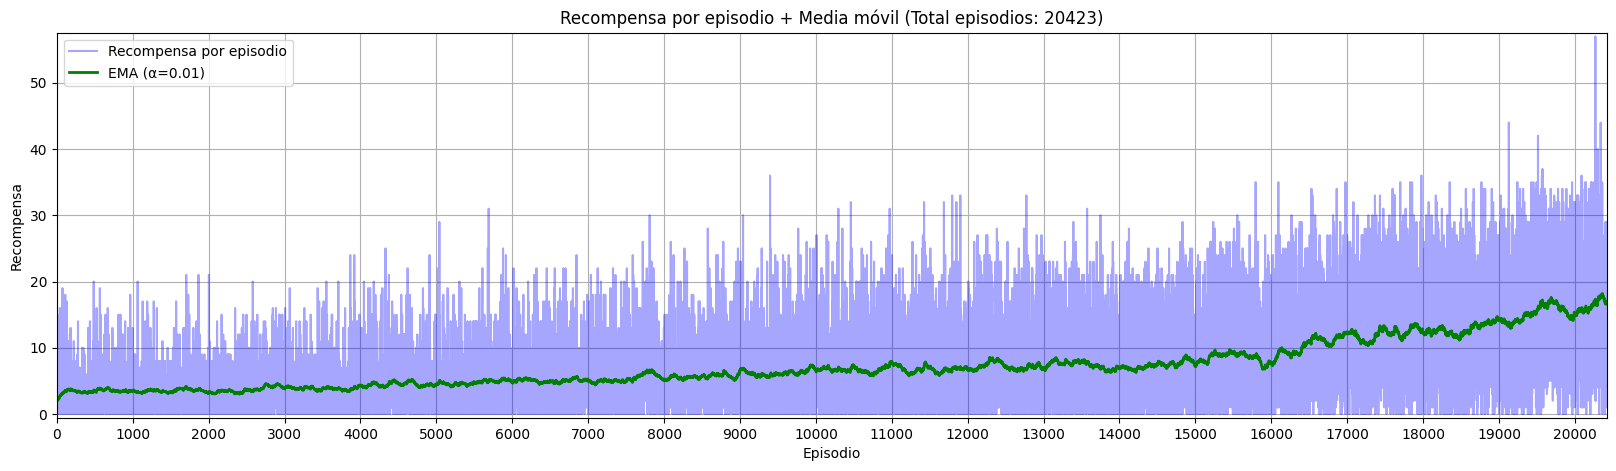

In [8]:
# llamada a funcion training para agente creado en PyTorch
n_tr = 1
TrainDQNtorch(agent, replay_buffer, optimizer, Training_Steps, BuildDcnn, N_Solucion, n_tr)


In [9]:
# Funcion test agente DQN PyTorch
def TestDQNtorch(agent, env, n_sol=1, n_train=1, n_episodes=100, Nepi_min=100, reward_min=20, visualize=False):
    """
    Ejecuta episodios de test sin exploración (epsilon=0) y sin actualizar pesos.
    """
    # Cargamos modelo
    model = agent.c_model
    
    # Parametros fijos
    max_steps = 1000
    HEIGHT, WIDTH = ef.INPUT_SHAPE
    N_FRAMES = ef.WINDOW_LENGTH
    
    # Cargar pesos modelo
    env_name = ef.ENV_NAME
    folder = Path(f"Solucion{n_sol}") 
    w_filename = folder / f'dqn{n_sol}_{env_name}_weights_final_{n_train}.pth'
    
    
    if w_filename is not None:
        model.load_state_dict(torch.load(w_filename, map_location=agent.device))
        print(f"Pesos cargados desde: {w_filename}")

    # Ponemos modelo en modo evaluación
    model.eval()
    
    # Ponemos el epsilon del agente en 0
    prev_epsilon = agent.epsilon
    agent.epsilon = 0 

    # Carga de entorno e incializacion buffer rewards.
    history = {"episode_reward": []}

    # Comenzamos test por episodios
    print(f"Evaluando performance del agente durante {n_episodes} episodios...")

    for ep in range(1, n_episodes + 1):
        obs = env.reset()
        state = update_frame_sequence(None, obs, n_frames=N_FRAMES, width=WIDTH, height=HEIGHT)
        total_reward = 0
        done = False

        # Mostrar numero epsiodio actual
        sys.stdout.write(f"\r  Episodio {ep}/{n_episodes}")
        sys.stdout.flush()

        # Bucle steps
        for step in range(max_steps):
            # 1.Visualizar partida si parametro entrada activo
            if visualize:
                env.render()
            
            # 2.Calculamos accion con el agente. Greedy pura
            action = agent.act(state, step)

            # 3.Ejecutamos accion en el entorno y obtenemos observación
            obs, reward, done, _ = env.step(action)

            # 4.Hacemos clipping del reward 
            reward = max(-1, min(1, reward))

            # 5.Incrementar recompensa
            total_reward += reward
  
            # 6.Procesado del siguiente estado 
            state = update_frame_sequence(state, obs, n_frames=N_FRAMES, width=WIDTH, height=HEIGHT) 
            
            if done:
                break

        # Guardamos reward del episodio
        history["episode_reward"].append(total_reward)
        
    # Restaurar epsilon original 
    agent.epsilon = prev_epsilon

    # Imprimimos resultado final
    print("\nTest finalizado.\n")
    print("Graficamos resultados test:")
    agent_eval(history, Nepi_min, reward_min)


Pesos cargados desde: Solucion4/dqn4_SpaceInvaders-v0_weights_final_1.pth
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 9.63 | Máximo: 25.00 | Mínimo: 2.00
Objetivo no alcanzado: Se han obtenido 4 de 100 episodios por encima de la puntuación. Es necesario seguir entrenando el agente.




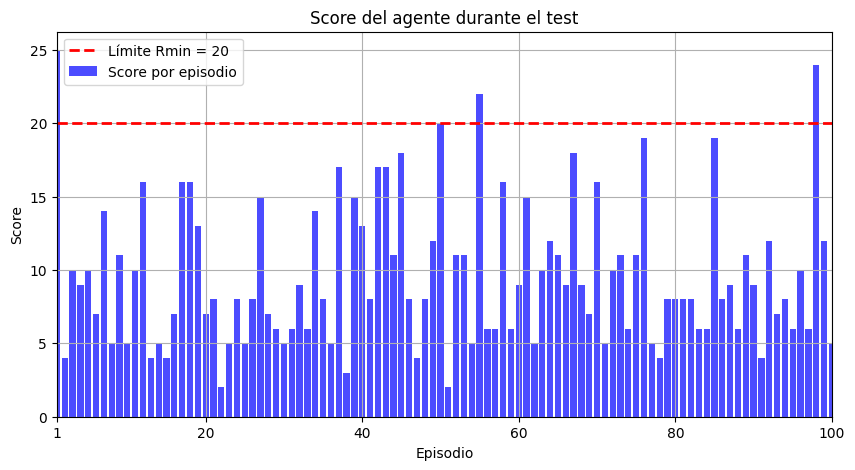

In [66]:
# Test de performance del agente
n_test= 100
TestDQNtorch(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)


##### 2.5.4.2 Etapa 2: Fine Tuning de 700k steps

Fichero Logs 'Solucion4/dqn4_SpaceInvaders-v0_log_2.json' cargado correctamente.

Interval 1 (100000 steps performed)
100000/100000 [====================] - 586s 5.9ms/step - reward: 0.1284
632 episodes - episode_reward: 20.339 [0.000, 53.000] - loss: 0.195 - mae: 1.022 - mean_q: 14.840 - mean_eps: 0.065
------------------------------------------------------------------------------------------
Interval 2 (100000 steps performed)
100000/100000 [====================] - 608s 6.1ms/step - reward: 0.1275
589 episodes - episode_reward: 21.633 [0.000, 54.000] - loss: 0.193 - mae: 1.055 - mean_q: 14.759 - mean_eps: 0.054
------------------------------------------------------------------------------------------
Interval 3 (100000 steps performed)
100000/100000 [====================] - 606s 6.1ms/step - reward: 0.1285
587 episodes - episode_reward: 21.899 [0.000, 43.000] - loss: 0.181 - mae: 1.041 - mean_q: 14.542 - mean_eps: 0.043
----------------------------------------------------------------

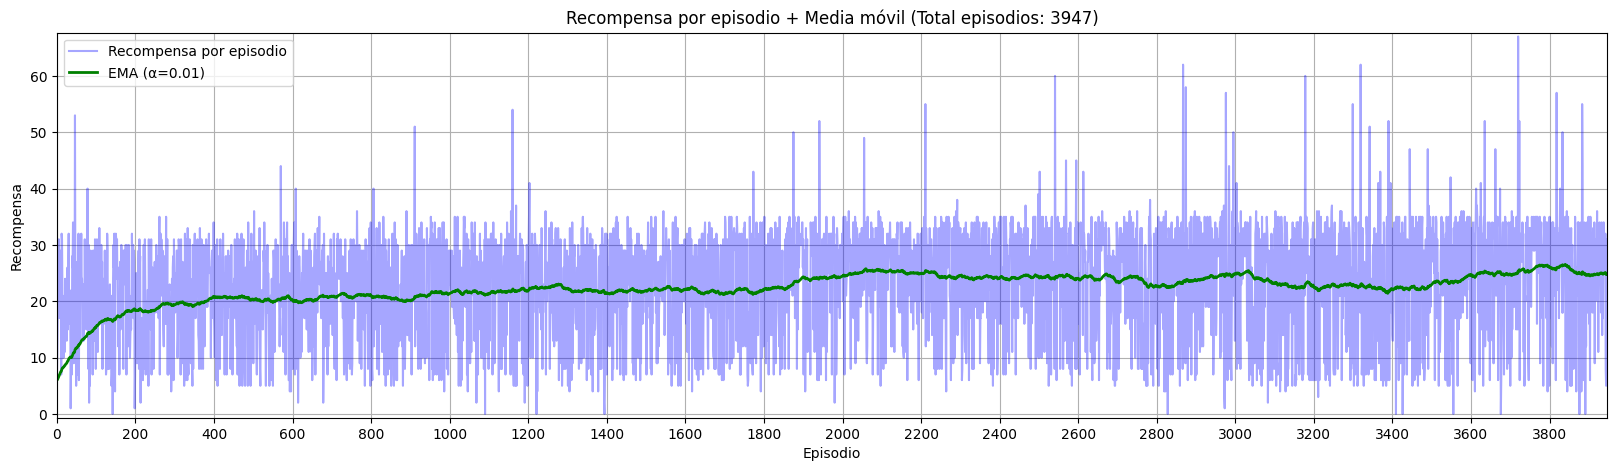

In [10]:
# Fijamos steps.
n_tr = 2
Training_Steps = 700000
decay_steps = int(Training_Steps*0.80)

# Reducimos learning rate para fine‑tuning
LearningRate = 0.000015
optimizer = optim.Adam(current_model.parameters(), lr=LearningRate)

# Actualizamos estrategia agente
# Continuamos ligeramente por encima del epsilon final de la etapa anterior y bajamos a 0.01 con el 75% de los steps.
# El 25% final el epsilon sera muy bajo para entrenar practicamente determinista.

agent.eps_start= 0.07              # Continua un poco por encima de la etapa anterior
agent.eps_final= 0.01              # termina casi determinista (1% aleatorio)
agent.eps_decay= decay_steps

agent.epsilon = agent.eps_start   # Reiniciamos epsilon

# Aumentamos el numero de pasos de actualizacion de la red para darle mas estabilidad.
agent.target_model_update= 25000

# llamada a funcion training para agente creado en PyTorch
TrainDQNtorch(agent, replay_buffer, optimizer, Training_Steps, BuildDcnn, N_Solucion, n_tr)


Pesos cargados desde: Solucion4/dqn4_SpaceInvaders-v0_weights_final_2.pth
Evaluando performance del agente durante 100 episodios...
  Episodio 100/100
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 100
Resultados Test (reward): Media: 34.20 | Máximo: 60.00 | Mínimo: 21.00
Objetivo alcanzado: Durante 100 episodios consecutivos se ha superado o igualado los 20 puntos.




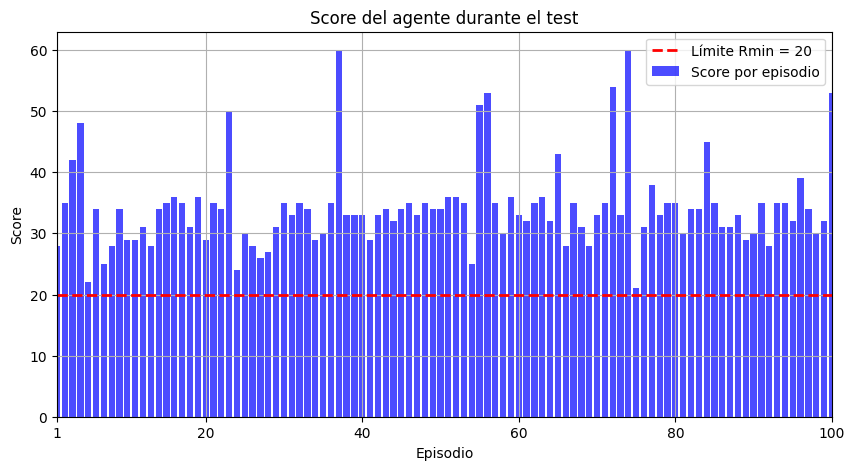

In [13]:
# Test de performance del agente
n_test= 100
TestDQNtorch(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)


#### 2.5.5 Justificación de los parámetros seleccionados y de los resultados obtenidos

---

JSON combinado guardado en: Solucion4/dqn4_SpaceInvaders-v0_log_FULL.json
Total episodios combinados: 24370


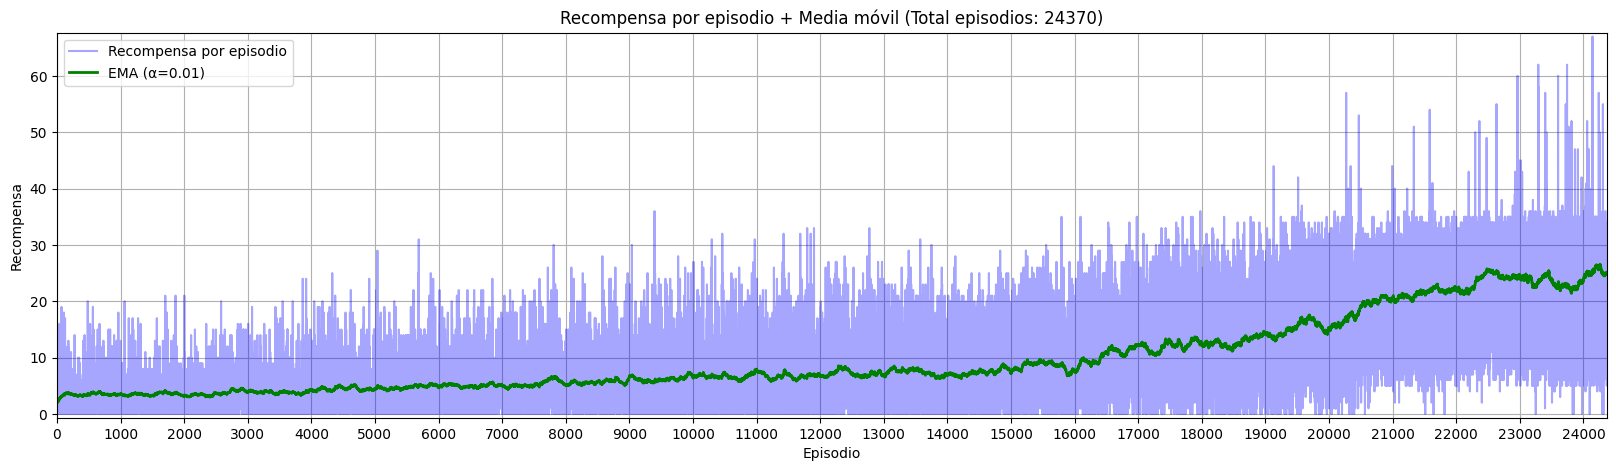

In [11]:
# Graficamos evolución de las 3 fases del entrenamiento
json_paths = [
    "Solucion4/dqn4_SpaceInvaders-v0_log_1.json",
    "Solucion4/dqn4_SpaceInvaders-v0_log_2.json",
]

merge_json_logs(json_paths, "Solucion4/dqn4_SpaceInvaders-v0_log_FULL.json")

plot_rewards("Solucion4/dqn4_SpaceInvaders-v0_log_FULL.json", 0.01)

Pesos cargados desde: Solucion4/dqn4_SpaceInvaders-v0_weights_final_2.pth
Evaluando performance del agente durante 300 episodios...
  Episodio 300/300
Test finalizado.

Graficamos resultados test:

El numero total de episodios ejecutados es: 300
Resultados Test (reward): Media: 33.79 | Máximo: 70.00 | Mínimo: 14.00
Objetivo superado: Durante 221 episodios consecutivos se ha superado o igualado los 20 puntos.




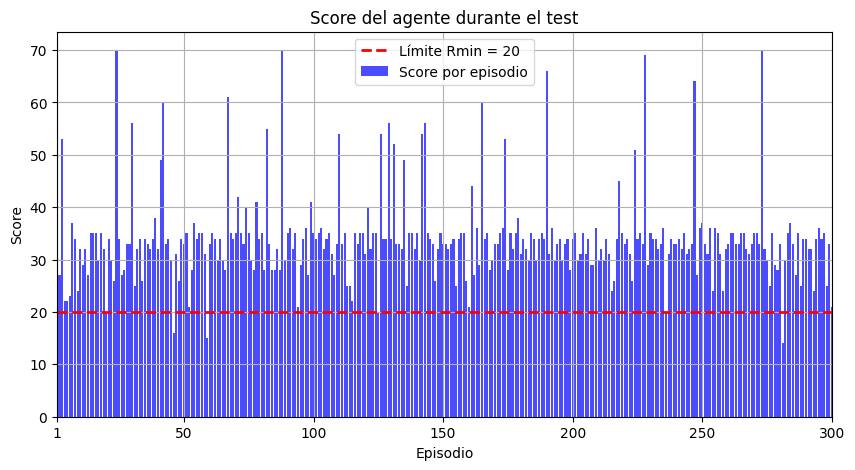

In [12]:
# Test de performance del agente durante 300 episodios
n_test= 300
TestDQNtorch(agent, env_te, N_Solucion, n_tr, n_test, Episodios_min, Reward_min, False)


Se ha realizado un entrenamiento por etapas:
- Etapa1: Inicialmente se optó por entrenar el modelo con 1.8M de steps. Se ha utilizado un learning rate de 0.00025 y una estrategia E-greedy con decaimiento progresivo desde 1 a 0.05. La red target se actualiza cada 10k steps.
- Etapa2: Se optó por una fase de ajuste fino de 700k steps adicionales para maximizar la política de explotación. Se ha utilizado un learning rate de 0.000015 y una estrategia E-greedy con decaimiento progresivo desde 0.07 a 0.01 para el 80% de los steps dejando el 20% final con epsilon fijo para hacer entrenamiento mas determinista. La red target se actualiza cada 25k steps para dar más estabilidad al aprendizaje y ayudar a que el error de los valores Q no oscile tanto.

Resultados:
- Tras 1.8M steps de entrenamiento, el test del agente ha dado un resultado de 4/100 episodios por encima de 20 puntos y una media de 9.63 puntos, siendo un resultado peor que el obtenido por el DQN basico a estas alturas. El aprendizaje del agente ha ido mejorando de forma lenta pero progresiva a lo largo de los 1.8M steps.
- Tras hacer un fine tunning de 700K steps adicionales el test del agente ha dado un resultado de 100/100 episodios por encima de 20 puntos y la media ha sido de 34.2 puntos. El agente ha progresado muchisimo en esta 2ª etapa y ya es capaz de superar el reto.
- Ejecutamos un test adicional de 300 episodios para ver comportamiento mas amplio. El resultado es de 221 episodios consecutivos por encima de 20 puntos y la media ha sido de 33.79 puntos.
- Analizando la curva completa de entrenamiento de 2.5M de steps, vemos que el agente ha tenido un progreso claro a través de las 2 etapas desarrolladas. 


## 2.6 Comparativa Final
A continuacion mostramos las graficas obtenidas para las 4 soluciones.

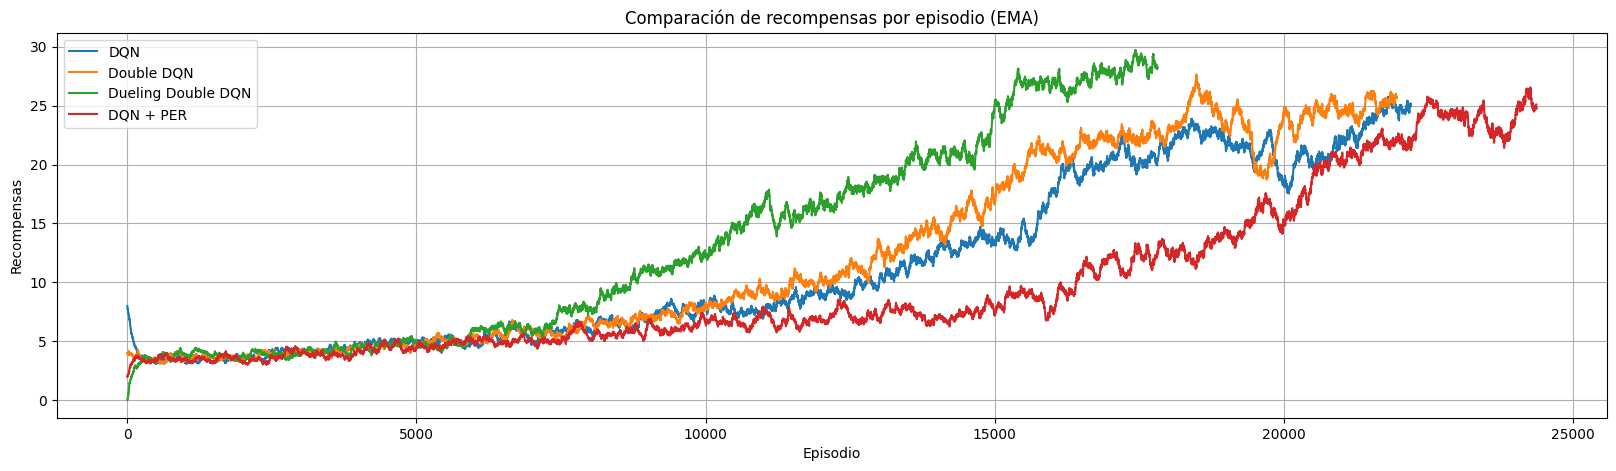

In [4]:
# Definimos ficheros de datos y labels.
json_files = [
    "Solucion1/dqn1_SpaceInvaders-v0_log_FULL.json",
    "Solucion2/dqn2_SpaceInvaders-v0_log_FULL.json",
    "Solucion3/dqn3_SpaceInvaders-v0_log_FULL.json",
    "Solucion4/dqn4_SpaceInvaders-v0_log_FULL.json",
]

labels = ["DQN", "Double DQN", "Dueling Double DQN", "DQN + PER"]

# Llamamos a funcion para plotear resultados
compara_solutions(json_files, labels, alpha=0.01)


En la gráfica anterior se aprecia claramente la superioridad de Dueling Double DQN frente al resto de soluciones. Aprende mucho más rápido y con menos episodios alcanza una puntuación más alta que las demás opciones.
Comparando DQN con DQN+PER, se observa que el aprendizaje inicial de DQN+PER es más lento y requiere más episodios para adquirir una política básica, pero a partir de ahí su pendiente de progreso no parece tocar techo. Aunque necesita más episodios para igualar la puntuación de DQN, si lo evaluamos en número de steps ha utilizado 2.5M frente a los 2.75M de DQN, por lo que realmente llega antes al resultado. Su dinámica de aprendizaje es claramente distinta.
Además, DQN+PER ha empleado un buffer de memoria menor (350k) que el resto de opciones.

**Importante:**
Como se aprecia en los logs, el entrenamiento realizado con **PyTorch** es mucho más rápido que el llevado a cabo con **Keras**, principalmente debido a un uso más eficiente de la CPU. En contraposición, esta mejora ha requerido desarrollar una mayor cantidad de código y gestionar manualmente aspectos que Keras abstrae de forma automática.


---
# 3. Anexos

## 3.1 Funciones libreria proyecto "env_functions.py"

In [4]:
# Como cargar directamente fichero .py y mostrarlo en el notebook.
with open("env_functions.py", "r", encoding="utf-8") as f:
    contenido = f.read()

display(Markdown(f"```python\n{contenido}\n```"))

```python
#==================================================================================================
#              08MIAR 2025 Grupo 21 - Fichero de Funciones Básicas Proyecto Programación RL
#==================================================================================================
#----------------------------- 1. Importación Librerias y funciones -------------------------------
import os
import glob
import json
import sys
import random
import gym
import numpy as np
import math
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from rl.agents.dqn import DQNAgent
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.core import Processor
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from collections import deque
from pathlib import Path 

#-------------------------------------- 2. Configuración Básica -----------------------------------
ENV_NAME = "SpaceInvaders-v0"
INPUT_SHAPE = (84, 84)     # (H, W)
WINDOW_LENGTH = 4          # stack in keras-rl memory/model

IM_SHAPE = (INPUT_SHAPE[0], INPUT_SHAPE[1], WINDOW_LENGTH)

#-------------------------------------- 3. Wrappers Gym Clasico -----------------------------------
# WRAPPERS (compatibles con gym clasico y keras-rl2)
# keras-rl2 espera:
#   reset() -> obs
#   step()  -> obs, reward, done, info

# MaxAndSkipEnv: aplica dos transformaciones clave:
# **Frame skipping**, ejecutando la misma acción durante varios pasos consecutivos.
# **Max-pooling** sobre los dos últimos frames observados.
class MaxAndSkipEnv(gym.Wrapper):
    """Frame-skip + max-pooling de los últimos 2 frames."""
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip
        self._obs_buffer = deque(maxlen=2)

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs  # keras-rl2 espera solo obs

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            terminated = terminated or done
            if done:
                break

        max_frame = np.maximum(self._obs_buffer[0], self._obs_buffer[-1])
        done = terminated
        return max_frame, total_reward, done, info  # keras-rl2 API

# FireResetEnv: tras cada `reset` ejecuta automáticamente la acción necesaria para iniciar la partida.
class FireResetEnv(gym.Wrapper):
    """Asegura que el juego arranque (SpaceInvaders puede requerir FIRE para empezar)."""
    def reset(self, **kwargs):
        obs = self.env.reset()

        # Acción 1 suele ser FIRE en SpaceInvaders ALE
        obs, _, done, info = self.env.step(1)

        if done:
            obs = self.env.reset()
        return obs
    
# NoopResetEnv: introduce una secuencia aleatoria de acciones nulas (`NOOP`) al inicio de cada episodio,
#               con un número máximo predefinido.
class NoopResetEnv(gym.Wrapper):
    """
    Ejecuta un número aleatorio de acciones NOOP tras reset.
    """
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max
        self.noop_action = 0  # NOOP en Atari

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)

        # Número aleatorio de NOOPs
        n_noops = np.random.randint(1, self.noop_max + 1)

        for _ in range(n_noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)

        return obs
    
# EpisodicLifeEnv: redefine el final de un episodio cada vez que el agente pierde una vida, 
#                  sin reiniciar completamente el entorno.
class EpisodicLifeEnv(gym.Wrapper):
    """
    Hace 'done=True' cuando se pierde una vida (pero no es game over).
    Acelera aprendizaje en Atari (solo recomendable en TRAIN).
    """
    def __init__(self, env, lives_key="ale.lives"):
        super().__init__(env)
        self.lives_key = lives_key
        self.lives = 0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.lives = 0
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)

        lives = info.get(self.lives_key, None)
        if lives is not None:
            if self.lives == 0:
                self.lives = lives

            # Si pierdes una vida pero NO es game over, cortamos el episodio
            if (lives < self.lives) and (lives > 0):
                done = True

            self.lives = lives

        return obs, reward, done, info


#--------------------------- 4. PROCESSOR (reward clipping + preprocessing) -----------------------
class AtariProcessor(Processor):
    def process_observation(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, INPUT_SHAPE, interpolation=cv2.INTER_AREA)
        return resized.astype(np.uint8)

    def process_state_batch(self, batch):
        return batch.astype("float32") / 255.0

    def process_reward(self, reward):
        return np.clip(reward, -1.0, 1.0)


#-------------------------------- 5. Funciones de monitorización ----------------------------------
# Función para evaluación resultado del agente.
def agent_eval(hist, Nepi=20, Rmin=20):
    """
    Evalúa el rendimiento del agente de acuerdo al enunciado del problema a partir de la historia de test.
    
    Parámetros:
    - hist: objeto devuelto por dqn.test()
    - Nepi: número de episodios consecutivos a comprobar (int)
    - Rmin: recompensa mínima exigida en cada episodio (int)
    
    Imprime:
    - número total de episodios ejecutados
    - media de recompensas
    - si ha superado el reto de N episodios consecutivos con reward >= Rmin
    """  
    # Extraemos puntuaciones del historial de episodios
    score = hist.get('episode_reward', [])
    
    # Calculamos numero total de episodios ejecutados. Si no hay ninguno nos salimos.
    total_Nepi = len(score)
    
    if total_Nepi <= 0:
        print("\nNo se detectan episodios en la historia del agente. No se puede evaluar su rendimiento")
        return

    print(f"\nEl numero total de episodios ejecutados es: {total_Nepi}")
    
    # Media total de recompensas
    score_avg = np.mean(score)
    score_max = np.max(score)
    score_min = np.min(score)
    print(f"Resultados Test (reward): Media: {score_avg:.2f} | Máximo: {score_max:.2f} | Mínimo: {score_min:.2f}")

    # Revisamos performance del agente
    Cmin = 0            # total de episodios con reward >= Rmin 
    Cmin_cont = 0       # contador consecutivo
    best_Cmin_cont = 0  # mejor contador consecutivo
    
    if total_Nepi >= Nepi:
        for val in score:
            if val >= Rmin:
                Cmin += 1
                Cmin_cont += 1
            else:
                best_Cmin_cont = max(best_Cmin_cont, Cmin_cont)
                Cmin_cont = 0
        
        if best_Cmin_cont == 0:
            best_Cmin_cont = Cmin_cont
        
        if best_Cmin_cont == Nepi:
            print(f"Objetivo alcanzado: Durante {Nepi} episodios consecutivos se ha superado o igualado los {Rmin} puntos.")
        elif best_Cmin_cont > Nepi:
            print(f"Objetivo superado: Durante {best_Cmin_cont} episodios consecutivos se ha superado o igualado los {Rmin} puntos.")
        else:
            print(f"Objetivo no alcanzado: Se han obtenido {Cmin} de {Nepi} episodios por encima de la puntuación. Es necesario seguir entrenando el agente.")

    else:
        print(f"Objetivo no alcanzado: No se ha evaluado el agente para el numero minimo de {Nepi} episodios requeridos.")   
        print(f"Se han obtenido {Cmin} de {total_Nepi} episodios por encima de la puntuación minima.") 
        
    # Sacamos grafica del test
    print(f"\n") 
    plt.figure(figsize=(10,5))

    # Eje X empezando en 1
    x_vals = range(1, len(score) + 1)

    plt.bar(x_vals, score, label="Score por episodio", alpha=0.7, color="blue")

    plt.axhline(y=Rmin, color='red', linestyle='--', linewidth=2,
                label=f"Límite Rmin = {Rmin}")

    plt.xlabel("Episodio")
    plt.ylabel("Score")
    plt.title("Score del agente durante el test")
    plt.grid(True)

    # Forzar que el eje X empiece en 1 
    plt.xlim(1, len(score))

    ax = plt.gca()
    ticks = ax.get_xticks()

    # Filtrar ticks no deseados (como el 0)
    ticks = [t for t in ticks if t >= 1]

    # Asegurar que el 1 aparece
    if 1 not in ticks:
        ticks = [1] + ticks

    ax.set_xticks(ticks)
    plt.legend()
    plt.show()

    
# Funcion para graficar evolución del reward obtenido por episodio
def plot_rewards(log_path, alpha=0.03):
    """
    Funcion que grafica las recompensa por episodio y la media móvil. Ambas en la misma figura.
    Parametros:
     - log_path: path del fichero log de entrenamiento
     - alpha: factor de suavizado de la EMA (0.02–0.05 recomendado)
    Retorno:
     - Grafica.
    """
    # Cargar JSON
    with open(log_path, "r") as f:
        data = json.load(f)

    # Extraer recompensas
    rewards = np.array(data["episode_reward"])
    n = len(rewards)

    # EMA (Exponential Moving Average)
    ema = np.zeros_like(rewards, dtype=float)
    ema[0] = rewards[0]
    for i in range(1, n): 
        ema[i] = alpha * rewards[i] + (1 - alpha) * ema[i - 1]
    
    # Crear figura
    plt.figure(figsize=(20, 5))

    # Curva original
    plt.plot(rewards, label="Recompensa por episodio", alpha=0.35, color="blue")

    # EMA 
    plt.plot(ema, label=f"EMA (α={alpha})", linewidth=2, color="green")
    
    # Ajustar eje Y
    ymin = rewards.min()
    ymax = rewards.max()
    margen = (ymax - ymin) * 0.01
    plt.ylim(ymin - margen, ymax + margen)
    
    # --- Ajuste dinámico del eje X ---
    if n < 2500:
        step = 100
    elif n < 5000:
        step = 200
    elif n < 7500:
        step = 500
    else:
        step = 1000

    plt.xlim(0, n - 1) 
    ticks = list(np.arange(0, n, step))
    plt.xticks(ticks)

    # Etiquetas y estilo
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title(f"Recompensa por episodio + Media móvil (Total episodios: {n})")
    plt.grid(True)
    plt.legend()
    plt.show()

# Funcion para graficar evolucion del reward obtenido por episodio
def merge_json_logs(json_paths, output_path):
    """
    Une varios ficheros JSON generados por Keras-RL en uno solo.
    Cada JSON debe contener la clave 'episode_reward'.
    """
    merged_rewards = []

    for path in json_paths:
        with open(path, "r") as f:
            data = json.load(f)
            rewards = data.get("episode_reward", [])
            merged_rewards.extend(rewards)

    # Guardamos el JSON combinado
    with open(output_path, "w") as f:
        json.dump({"episode_reward": merged_rewards}, f)

    print(f"JSON combinado guardado en: {output_path}")
    print(f"Total episodios combinados: {len(merged_rewards)}")
    
# Funciones para mostrar en celda los datos del entrenamiento realizado.
# Limpiar Valores
def clean_values(values):
    """Devuelve solo números válidos, filtrando None, '', [], nan."""
    cleaned = []
    for v in values:
        if isinstance(v, (int, float)) and not np.isnan(v):
            cleaned.append(v)
    return cleaned

# Calcula media de una lista eliminando errores y NaN
def safe_mean(values):
    """Media segura: si no hay valores válidos → 0."""
    vals = clean_values(values)
    if len(vals) == 0:
        return 0.0
    return float(np.mean(vals))

# Muestra los resultados del training accediendo al fichero log .json
def ShowLastTraining(log_path="training_log.json", steps_por_intervalo=100000):
    # Leer JSON
    with open(log_path, "r") as f:
        print(f"Mostramos los datos del entrenamiento realizado:\n")
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print("Warning: El fichero JSON está vacío o corrupto.")
            return

    # Comprobar si faltan campos obligatorios o están vacíos
    campos_obligatorios = ["episode", "episode_reward", "nb_steps", "nb_episode_steps", "duration"]

    for campo in campos_obligatorios:
        if campo not in data or not data[campo]:
            print(f"Warning: El fichero JSON no contiene datos suficientes ({campo} está vacío).")
            return

    # Extraer campos obligatorios
    episodes       = data["episode"]
    rewards        = data["episode_reward"]
    nb_steps       = data["nb_steps"]
    nb_ep_steps    = data["nb_episode_steps"]
    duraciones     = data["duration"]

    # Campos opcionales
    optional_fields = {
        "loss":      data.get("loss"),
        "mae":       data.get("mae"),
        "mean_q":    data.get("mean_q"),
        "mean_eps":  data.get("mean_eps"),
        "ale.lives": data.get("ale.lives"),
    }

    # Filtrar solo los que existen realmente
    optional_fields = {k: v for k, v in optional_fields.items() if v is not None}

    # Si nb_steps está vacío, no hay nada que mostrar
    if not nb_steps:
        print("Warning: No hay pasos registrados en el fichero JSON.")
        return

    max_steps = nb_steps[-1]
    # num_intervalos = max_steps // steps_por_intervalo
    num_intervalos = math.ceil(max_steps / steps_por_intervalo)

    if num_intervalos == 0:
        print("Warning: No hay suficientes pasos para mostrar intervalos.")
        return
 
    # Recorrer intervalos e imprimirlos en pantalla
    total_episodes = 0
    
    for k in range(1, num_intervalos + 1):
        inicio = (k - 1) * steps_por_intervalo
        fin    = k * steps_por_intervalo
        
        idx = [i for i, s in enumerate(nb_steps) if inicio < s <= fin]
        if not idx:
            continue

        r_int      = [rewards[i]     for i in idx]
        dur_int    = [duraciones[i]  for i in idx]
        steps_ep   = [nb_ep_steps[i] for i in idx]

        r_mean  = safe_mean(r_int)
        r_min   = float(np.min(r_int))
        r_max   = float(np.max(r_int))
        dur_tot = float(np.sum(dur_int))
        ms_mean = (dur_tot * 1000.0) / steps_por_intervalo

        episodios_intervalo = len(idx)
        total_episodes += episodios_intervalo

        linea_final = (
            f"{episodios_intervalo} episodes - "
            f"episode_reward: {r_mean:.3f} [{r_min:.3f}, {r_max:.3f}]"
        )

        for campo, valores in optional_fields.items():
            valores_intervalo = [valores[i] for i in idx]
            media = safe_mean(valores_intervalo)

            if campo == "ale.lives":
                vivos = clean_values(valores_intervalo)
                ultimo = vivos[-1] if len(vivos) > 0 else 0.0
                linea_final += f" - ale.lives: {ultimo:.3f}"
            else:
                linea_final += f" - {campo}: {media:.3f}"

        if fin >= max_steps:
            fin = max_steps

        print(f"Interval {k} ({fin} steps performed)")
        print(
            f"{steps_por_intervalo}/{steps_por_intervalo} [==============================] "
            f"- {int(dur_tot):d}s {ms_mean:.0f}ms/step - reward: {r_mean:.4f}"
        )
        print(linea_final)
        print("-" * 90)

    # Calcular tiempo total y numero de episodios
    tr_total_t = np.sum(duraciones)
    tr_steps = fin
    
    # Media final de ms/step
    ms_per_step_total = ((tr_total_t / tr_steps) * 1000) if tr_steps > 0 else 0

    # Imprime resumen final
    print(
        f"\n==== TRAINING COMPLETADO ==== | "
        f"Total steps: {tr_steps} | "
        f"Episodes: {total_episodes} | "
        f"Total time: {tr_total_t:.1f}s {ms_per_step_total:.0f}ms/step | "
        f"=====\n"
    )


#---------------------------------- 6. Funciones de training & test -------------------------------
# Crea el entrono de simulacion para training y/o test
def make_env(seed: int, training: bool):
    env = gym.make(ENV_NAME)

    env = NoopResetEnv(env, noop_max=30)
    env = FireResetEnv(env)  

    # Episodic life SOLO en training
    if training:
        env = EpisodicLifeEnv(env, lives_key="ale.lives")

    env = MaxAndSkipEnv(env, skip=4)

    try:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    except TypeError:
        env.seed(seed)
        env.reset()

    return env

# Funcion para definir la semilla
def set_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Funcion para entrenar al agente
def TrainAgent(agent, env, tr_steps, n_sol=1, n_train=1):
    
    # Crear carpeta de la solución 
    folder = Path(f"Solucion{n_sol}") 
    folder.mkdir(exist_ok=True)

    # Ficheros finales
    env_name = ENV_NAME
    w_filename = folder / f'dqn{n_sol}_{env_name}_weights_final_{n_train}.h5f'
    
    checkpoint_filename = folder / f'dqn{n_sol}_{env_name}_weights_{{step}}.h5f'
    log_filename = folder / f'dqn{n_sol}_{env_name}_log_{n_train}.json'
    
    # Callbacks para guardar pesos y logs periódicamente
    callback_1 = ModelIntervalCheckpoint(str(checkpoint_filename), interval=100000)
    callback_2 = FileLogger(str(log_filename), interval=1)

    # Combinamos todos los callbacks
    callbacks = [callback_1, callback_2]

    # Cargar pesos si existe el fichero de training y mostrar el log de resultados pasados
    if glob.glob(str(w_filename) + "*"):
        print(f"Cargando pesos: {w_filename}")
        agent.load_weights(w_filename)
        
        if glob.glob(str(log_filename) + "*"):
            ShowLastTraining(log_filename, 100000)
    else:
        # Entrenar agente desde 0 y guardar pesos al finalizar.
        print("No se encontraron pesos previos, entrenando desde cero...")
        agent.fit(env, nb_steps=tr_steps, visualize=False, verbose=1, callbacks=callbacks, log_interval=100000)
        agent.save_weights(w_filename, overwrite=True)
        print(f"\nPesos guardados en: {w_filename}")

    # Graficamos resultados entrenamiento
    plot_rewards(log_filename, 0.01)

# Funcion para testear al agente
def TestAgent(agent, env, n_sol=1, n_train=1, n_test=100, Nepi_min=100, reward_min=20, visualize=False):
    """
    Evalúa el rendimiento del agente de acuerdo al enunciado del problema a partir de la historia de test.
    
    Parámetros:
    - agent: objeto con el agente definido
    - env: objeto con el entorno definido.
    - n_sol: numero de experimento ejecutado (int).
    - n_train: numero de training dentro del experimento (int).
    - n_test: numero de tests a ejecutar (int)
    - Nepi_min: número de episodios consecutivos a comprobar (int)
    - reward_min: recompensa mínima exigida en cada episodio (int)
    - visualize: =True ver pantalla juego.
    """

    env_name = ENV_NAME
    folder = Path(f"Solucion{n_sol}") 
    w_filename = folder / f'dqn{n_sol}_{env_name}_weights_final_{n_train}.h5f'
        
    if glob.glob(str(w_filename) + "*"):
        print(f"Cargando pesos para test: {w_filename}")
        agent.load_weights(w_filename)

    agent.policy = EpsGreedyQPolicy(eps=0.0)

    print(f"Evaluando performance del agente durante {n_test} episodios...")

    history = {"episode_reward": []}

    for i in range(1, n_test + 1):
        sys.stdout.write(f"\r  Episodio {i}/{n_test}")
        sys.stdout.flush()
        result = agent.test(env, nb_episodes=1, visualize=visualize, verbose=0)
        reward = result.history["episode_reward"][0]
        history["episode_reward"].append(reward)

    print("\nTest finalizado.\n")
    print("Graficamos resultados test:")
    agent_eval(history, Nepi_min, reward_min)
    

# Funcion para comprar resultados finales
def compara_solutions(json_paths, labels=None, alpha=0.1):
    """
    Carga varios ficheros JSON de logs de entrenamiento y compara sus recompensas usando EMA.

    Parámetros:
    - json_paths: lista de rutas a los ficheros JSON.
    - labels: nombres para cada curva (si None, usa los nombres de archivo).
    - alpha: factor de suavizado EMA (0.05–0.2 recomendado).
    """

    if labels is None:
        labels = [f"Modelo {i+1}" for i in range(len(json_paths))]

    plt.figure(figsize=(20, 5))

    for path, label in zip(json_paths, labels):

        # Cargar JSON
        with open(path, "r") as f:
            data = json.load(f)

        rewards = data.get("episode_reward", [])

        if not rewards:
            print(f"No se encontraron recompensas en {path}")
            continue

        # Calculo EMA
        ema = []
        s = rewards[0]
        for r in rewards:
            s = alpha * r + (1 - alpha) * s
            ema.append(s)
        ema = np.array(ema)

        plt.plot(ema, label=label)

    plt.title("Comparación de recompensas por episodio (EMA)")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensas")
    plt.grid(True)
    plt.legend()
    plt.show()

```

## 3.2 Funciones libreria proyecto "torch_functions.py"

In [7]:
# Como cargar directamente fichero .py y mostrarlo en el notebook.
with open("torch_functions.py", "r", encoding="utf-8") as f:
    contenido = f.read()

display(Markdown(f"```python\n{contenido}\n```"))

```python
#!/usr/bin/env python
# coding: utf-8
#==================================================================================================
#              08MIAR 2025 Grupo 21 - Fichero de Funciones PyTorch Proyecto Programación RL
#==================================================================================================
#----------------------------- 1. Importación Librerias y funciones -------------------------------
import os
import json
import time
import math
import random
import numpy as np
import torch
import copy
import cv2
from collections import deque
from IPython.display import clear_output
from env_functions import plot_rewards
import matplotlib.pyplot as plt

#-------------------------------------- 2. Configuración Básica -----------------------------------
# Funciones Adicionales para Pytorch   
# Buffer memoria PER
class ReplayBufferPER(object):
    def __init__(self, capacity, prob_alpha=0.6):
        """
        capacity: tamaño máximo del buffer
        prob_alpha: controla cuánta prioridad se aplica (0 = uniforme, 1 = totalmente prioritizado)
        """
        self.capacity   = capacity
        self.prob_alpha = prob_alpha

        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    # Insertar nueva transición en el buffer.
    def push(self, state, action, reward, next_state, done):
        """
        Guarda una transición en el buffer.
        state y next_state deben ser uint8 con shape (C,H,W)
        """
        # ELIMINA los np.expand_dims, guarda el array tal cual (C, H, W)
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        # Manejo de prioridad inicial
        max_prio = self.priorities.max() if self.buffer else 1.0
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    # Devolver batch de muestras usando PER
    def sample(self, batch_size, beta=0.4):
        """
        Devuelve un batch PER:
        - states, actions, rewards, next_states, dones
        - indices del buffer
        - importance sampling weights
        """
        current_size = len(self.buffer)
        prios = self.priorities[:current_size]

        # Probabilidades proporcional a la prioridad
        probs = prios ** self.prob_alpha
        s = probs.sum()
        
        # Prteccion contra NaNs o sumas cero
        if s == 0 or np.isnan(s):
            probs =  np.ones_like(probs) / len(probs)
        else:
            probs /= s

        # Selección de índices según probs
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)

        # Extraer muestras
        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convertir a arrays numpy
        # states      = np.vstack(states)      # (B, C, H, W)
        # next_states = np.vstack(next_states)
        states      = np.stack(states)      # (B, C, H, W)
        next_states = np.stack(next_states)

        actions     = np.array(actions, dtype=np.int64)
        rewards     = np.array(rewards, dtype=np.float32)
        dones       = np.array(dones, dtype=np.uint8)

        # Importance Sampling Weights
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = weights.astype(np.float32)

        return states, actions, rewards, next_states, dones, indices, weights

    # Actualiza las prioridades de las transiciones muestreadas
    def update_priorities(self, indices, priorities):
        """
        Actualiza prioridades después de calcular TD-error.
        """        
        max_prio = 1e4
        
        for idx, prio in zip(indices, priorities):
            # if np.isnan(prio) or prio <= 0:
            #     prio = 1e-6
            # self.priorities[idx] = prio
            
            prio = float(prio)
            # Si es NaN, asignamos prioridad mínima
            if np.isnan(prio) or prio <= 0:
                prio = 1e-6

            # Clipping para evitar explosiones numéricas
            if prio > max_prio:
                prio = max_prio

            self.priorities[idx] = prio

    # Devuelve el número actual de transiciones almacenadas en el buffer
    def __len__(self):
        return len(self.buffer)

# Time difference loss calculation para buffer PER.
# Actualiza la red principal con nuevos pesos para un batch de transiciones.
def compute_td_loss_PER(c_model, t_model, optimizer, replay_buffer, device, batch_size=32, gamma=0.99, beta=0.4, clipnorm=0, huberloss= False):

    # Sample con PER
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # Convertir a tensores
    state      = torch.from_numpy(state).to(device)
    next_state = torch.from_numpy(next_state).to(device)
    action     = torch.from_numpy(action).long().to(device)
    reward     = torch.from_numpy(reward).float().to(device)
    done       = torch.from_numpy(done).float().to(device)
    weights    = torch.from_numpy(weights).float().to(device)

    # Normalización
    state = state.float() / 255.0
    next_state = next_state.float() / 255.0

    # Q(s,a)
    q_values = c_model(state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    mean_q_batch = q_values.mean().item()

    # Q_target(s',a')
    with torch.no_grad():
        next_q_values = t_model(next_state)
        next_q_value = next_q_values.max(1)[0]

    # Bellman target
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    # Calculamos valor Q esperado (Bellman)
    td_error = q_value - expected_q_value.detach()

    # Loss para PER (huber o MSE)
    if huberloss:
        huber = torch.nn.functional.smooth_l1_loss(q_value, expected_q_value, reduction='none')
        loss = (weights * huber).mean()
    else:
        loss = (weights * td_error.pow(2)).mean()

    # MAE del batch
    mae_batch = torch.abs(td_error).mean().item()

    # Limpiamos gradientes anteriores y hacemos calculo gradientes nuevos mediante loss.backward
    optimizer.zero_grad()
    loss.backward()

    # Actualizamos pesos con ClipNorm
    if clipnorm > 0:
        torch.nn.utils.clip_grad_norm_(c_model.parameters(), max_norm=clipnorm)
        
    optimizer.step()

    # Devolver prioridades nuevas (abs del TD-error)
    new_priorities = td_error.abs().detach().cpu().numpy() + 1e-6
    
    # Actualiza prioridades del buffer
    replay_buffer.update_priorities(indices, new_priorities)
    
    # Compcta datos para salida
    td_data = [loss.item(), mean_q_batch, mae_batch]

    # Devolvemos la datos salida calculados
    return td_data


# Mi agente DQN. Calcula la accion en cada Step.
class DQNag:
    # Inicializamos el agente
    def __init__(self, c_model, n_actions, env, eps_start=1.0, eps_final=0.01, eps_decay=30000, exp_decay= False,
                       nb_steps_warmup=50000, train_interval=4, target_model_update=10000, batch_size=32, gamma=0.99, 
                       soft_update=False, tau=0.005):
        # Cargamos device, modelo y numero acicones
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.c_model = c_model.to(self.device)
        self.n_actions = n_actions      

        # Parámetros de epsilon
        self.eps_start = eps_start
        self.eps_final = eps_final
        self.eps_decay = eps_decay
        self.exp_decay = exp_decay

        # Parámetros de entrenamiento 
        self.env = env
        self.nb_steps_warmup = nb_steps_warmup 
        self.train_interval = train_interval 
        self.target_model_update = target_model_update 
        self.batch_size = batch_size 
        self.gamma = gamma
        self.soft_update = soft_update 
        self.tau = tau

        # Valor actual de epsilon (inicialmente el máximo) 
        self.epsilon = eps_start
    
    # Calculamos acción según metodo €-greedy
    def act(self, state, n_step):
        # Calculo epsilon con decaimiento exponencial o lineal.
        if self.eps_decay > 0:
            if self.exp_decay:
                self.epsilon = self.eps_final + (self.eps_start - self.eps_final) * math.exp(-1.0 * n_step / self.eps_decay)
            else:
                decay_rate = (self.eps_start - self.eps_final) / self.eps_decay
                self.epsilon = max(self.eps_final, self.eps_start - decay_rate * n_step)
        else:
            self.epsilon = self.eps_final
        
        # Politica €-greedy. Muestreamos y si el valor < epsilon --> seleccionamos una accion aleatoria
        if random.random() < self.epsilon:               
            act = random.randrange(self.n_actions)
               
        # Politica €-greedy. Muestreamos y si el valor >= epsilon --> seleccionar el maximo q-value del modelo 
        else:
            state_t = torch.from_numpy(state).unsqueeze(0).to(self.device, dtype=torch.float32) / 255.0
                                                                             # Añadimos 1 dimension para eu la CNN lo pueda procesar
                                                                             # (C, H, W) → (1, C, H, W)          
            with torch.no_grad():                   # Evitamos que PyTorch calcule gradientes en este punto
                q_value = self.c_model(state_t)     # cargamos estado en la red y obtenemos las 6 opciones Q-values
                act = q_value.argmax(dim=1).item()  # Seleccionamos el indice con el valor Q maximo como accion.

        # Devuelve el numero de acción a ejecutar (int).
        return act
    
# Funcion actualizacion de la red target. Copia todos los pesos de la red principal a la target.   
def update_target(c_model, t_model, tau=0.005, soft_update=False):
    with torch.no_grad(): # Evita el rastreo de gradientes innecesario
        # Soft update
        if soft_update and (0.0 <= tau <= 1.0):
            for target_param, param in zip(t_model.parameters(), c_model.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        
        # Hard update
        else:
            t_model.load_state_dict(c_model.state_dict())

# Funcion para gestionar logs en PyTorch
class LogTorch:
    def __init__(self, interval=10000, tr_steps=10000):
        # Entradas
        self.steps_per_interval = max(1,min(interval, tr_steps))
        self.tr_steps = tr_steps
         
        # Parametros
        self.bar_length = 20 
        self.n_steps_print = 200

        # variables internas       
        self.n_steps_int, self.n_int_actual, self.n_episodes_int = 0,0,0
        self.last_start_time = time.time()
        
        # Acumuladores
        self.reward_acc, self.eps_acc, self.mae_acc = 0,0,0
        self.loss_acc, self.qvalue_acc = 0,0
        
        # Estadisticas por episodio
        self.episode_reward, self.reward_previo, self.reward_epi_acc = 0,0,0
        self.reward_N, self.eps_mean, self.mae_mean, self.loss_mean, self.qvalue_mean, = 0,0,0,0,0
        self.loss, self.q_batch, self.mae_batch = 0,0,0
               
        # Diccionario para logs
        self.dict_datos_intervalo = {    
            "reward_mean": 0.0,
            "reward_min": 100.0,
            "reward_max": 0.0,
            "reward_N": 0.0,
            "eps_mean": 0.0,
            "mae_mean": 0.0,
            "loss_mean": 0.0,
            "qvalue_mean": 0.0,
            "n_episodes": 0,
            "n_steps": 0.0,
            "duration": 0.0,
            "ms_step": 0.0
        }

        # Buffers por episodio
        self.all_rewards = []
        
        # Buffer por intervalo
        self.num_intervalos = tr_steps//self.steps_per_interval
        self.datos_intervalo = [
            copy.deepcopy(self.dict_datos_intervalo) for _ in range(self.num_intervalos)
        ]
        
        # Buffer calculos ciclicos
        self.datos_actuales = copy.deepcopy(self.dict_datos_intervalo)

    @staticmethod 
    def to_python(obj): 
        if hasattr(obj, "item"): 
            return obj.item() 
        return obj
        
    # Funcion que calcula los datos a mostrar durante el entrenamiento
    def update_interval(self, n_step, TD_data, done, reward, epsilon):
        # Extramemos TD
        loss, q_batch, mae_batch = TD_data       

        # Calculo valores acumulados en el intervalo
        self.n_steps_int += 1 
        self.reward_acc += reward       
        self.eps_acc += epsilon
        self.mae_acc += mae_batch
        self.loss_acc += loss
        self.qvalue_acc += q_batch
  
        # Calculo valores ciclicos
        if self.n_steps_int > 0:
            self.datos_actuales["reward_N"] = self.reward_acc/self.n_steps_int
            self.datos_actuales["eps_mean"] = self.eps_acc/self.n_steps_int
            self.datos_actuales["mae_mean"] = self.mae_acc/self.n_steps_int
            self.datos_actuales["loss_mean"] = self.loss_acc/self.n_steps_int
            self.datos_actuales["qvalue_mean"] = self.qvalue_acc/self.n_steps_int

        self.datos_actuales["duration"] = time.time() - self.last_start_time  
        self.datos_actuales["ms_step"] = 0
        self.datos_actuales["n_steps"] = self.n_steps_int

        # Calculo valores por episodio
        if done: 
            # Valores reward
            self.episode_reward = self.reward_acc - self.reward_previo
            self.reward_previo = self.reward_acc
            self.reward_epi_acc += self.episode_reward
            self.datos_actuales["reward_max"]= max(self.datos_actuales["reward_max"], self.episode_reward)

            if self.n_episodes_int > 0:
                self.datos_actuales["reward_mean"] = self.reward_epi_acc / self.n_episodes_int
                self.datos_actuales["reward_min"]= min(self.datos_actuales["reward_min"], self.episode_reward)
            else:
                self.datos_actuales["reward_mean"] = self.reward_epi_acc
                self.datos_actuales["reward_min"]= 100

            # Incrementamos numero episodios en este intervalo y lo guardamos
            self.n_episodes_int += 1
            self.datos_actuales["n_episodes"] = self.n_episodes_int
            
            # Guardamos reward episodio en buffer global
            self.all_rewards.append(self.episode_reward)
    
        # Inicio nuevo intervalo
        if n_step % self.steps_per_interval == 0:
            # Capturamos instante tiempo
            start_time = time.time()

            # Guardar copia del intervalo
            self.datos_intervalo[self.n_int_actual] = copy.deepcopy(self.datos_actuales)
           
            # Ajustar valores finales del intervalo
            dur = start_time - self.last_start_time 
            self.datos_intervalo[self.n_int_actual]["duration"] =  dur
            self.datos_intervalo[self.n_int_actual]["ms_step"] = 1000*(dur/self.steps_per_interval)
            self.datos_actuales["n_steps"] = self.steps_per_interval

            # Guardamos tiempo para siguiente intervalo
            self.last_start_time = start_time
            
            # Reseteamos contadores acumulados
            self.n_episodes_int = 0
            self.n_steps_int = 0
            self.reward_acc, self.eps_acc, self.mae_acc, self.loss_acc, self.qvalue_acc = 0,0,0,0,0

            # Reseteamos calculos
            self.episode_reward, self.reward_previo, self.reward_epi_acc = 0,0,0
            self.datos_actuales["reward_max"]= 0
            self.datos_actuales["reward_min"]= 100
            self.datos_actuales["reward_mean"]= 0
            
        
        # Imprimir datos en pantalla
        self.print_data(n_step, self.datos_intervalo[self.n_int_actual], self.n_int_actual, True)
                   
        # Imprimimos resumen final si es el ultimo step.
        if (n_step == self.tr_steps) :
            self.print_final(self.datos_intervalo)

        # Incrementar contador intervalos
        if (n_step % self.steps_per_interval == 0) and (n_step < self.tr_steps):
            self.n_int_actual += 1

    # Funcion que inprime en pantalla datos en tiempo real
    def print_data(self, n_step, int_data, n_int_actual, TrainingOn= False):
        
        # Imprimimos primera linea cuando se incrementa el intervalo
        if (n_step % self.steps_per_interval == 1) or not TrainingOn:
            print(f"Interval {n_int_actual+1} ({self.steps_per_interval} steps performed)")   

        # Imprimimos progreso dentro del intervalo - cada X steps
        if (n_step % self.n_steps_print == 0) and TrainingOn:   
            steps_left = self.steps_per_interval - self.datos_actuales["n_steps"]
            ratio_eta = (self.datos_actuales["duration"] / self.steps_per_interval) if self.steps_per_interval > 0 else 0
            ratio_steps = (self.datos_actuales["n_steps"] / self.steps_per_interval) if self.steps_per_interval > 0 else 0
            eta = ratio_eta * steps_left
            
            filled = int(self.bar_length * ratio_steps)
            bar = "=" * filled + "." * (self.bar_length - filled)

            act_rewardN = self.datos_actuales["reward_N"]
            
            # Línea de progreso (siempre en la misma línea)
            print(
                f"\r{self.n_steps_int}/{self.steps_per_interval} [{bar}] - ETA: {eta:.1f}s - reward: {act_rewardN:.3f}",
                end=""
            )

        # Imprimir en pantalla datos actuales
        if (n_step % self.steps_per_interval == 0) and TrainingOn or not TrainingOn:                    
            # Fin del intervalo - imprimimos segunda linea con resultados
            
            intervale_duration = int_data["duration"]
            intervale_ms_step = int_data["ms_step"]
            mean_reward_N = int_data["reward_N"]
            mean_reward = int_data["reward_mean"]
            min_reward = int_data["reward_min"]
            max_reward = int_data["reward_max"]
            mean_epi_loss = int_data["loss_mean"]
            mean_epi_mae = int_data["mae_mean"]
            mean_epi_q = int_data["qvalue_mean"]
            mean_epi_eps = int_data["eps_mean"]
            n_episodes = int_data["n_episodes"]
            
            print(
                f"\r{self.steps_per_interval}/{self.steps_per_interval} "
                f"[{'=' * self.bar_length}] - {intervale_duration:.0f}s "
                f"{intervale_ms_step:.1f}ms/step - reward: {mean_reward_N:.4f}"
            )
            print(
                f"{n_episodes} episodes - "
                f"episode_reward: {mean_reward:.3f} [{min_reward:.3f}, {max_reward:.3f}] - "
                f"loss: {mean_epi_loss:.3f} - mae: {mean_epi_mae:.3f} - "
                f"mean_q: {mean_epi_q:.3f} - mean_eps: {mean_epi_eps:.3f}"
            )
            print("-" * 90)
      
    # Funcion que imprime resumen final
    def print_final(self, datos_intervalo):
        
        # Inicializar variable funcion
        tr_total_t, total_episodes = 0,0 
        
        # Calculamos datos totales intervalos
        for tr_data in datos_intervalo:
            tr_total_t += np.sum(tr_data["duration"])
            total_episodes += np.sum(tr_data["n_episodes"])
        
        # Media final de ms/step
        ms_per_step_total = ((tr_total_t / self.tr_steps) * 1000) if self.tr_steps > 0 else 0
        
        print(
            f"\n==== TRAINING COMPLETADO ==== | "
            f"Total steps: {self.tr_steps} | "
            f"Episodes: {total_episodes} | "
            f"Total time: {tr_total_t:.1f}s {ms_per_step_total:.0f}ms/step | "
            f"=====\n"
        )

    # Funcion que carga los datos del fichero log de un entrenamiento anterior
    def load_log(self, log_filename):
        # Chequeamos si existe el fichero. Devovemos False sino lo hay-      
        if not os.path.exists(log_filename): 
            return False
    
        try:
            # abrir fichero logs
            with open(log_filename, "r") as f:
                log_data = json.load(f)

            print(f"Fichero Logs '{log_filename}' cargado correctamente.\n") 
                   
            # Imprimir datos en pantalla
            for ni, data_interval in enumerate(log_data['intervals']):
                self.print_data(-1, data_interval, ni, False)
            self.print_final(log_data['intervals'])

            return True
        
        # Si hay error lo mostramos y devolvemos False
        except json.JSONDecodeError: 
            print(f"Error: el fichero '{log_filename}' está corrupto o no es JSON válido.") 
            return False

    # Funcion que salva los datos del entrenamiento en un fichero .json
    def save_log(self, log_filename):
        logdata= {
            "intervals": self.datos_intervalo,
            "episode_reward": self.all_rewards
        }

        # Salvamos fichero logs
        with open(log_filename, "w") as f:
            json.dump(logdata, f, indent=4, default=self.to_python)

        # Chequeamos si existe el fichero. Devovemos False sino lo hay-      
        print(f"\nFichero datos entrenamiento {log_filename} guardado correctamente.")

## Funciones para pre-procesado
# Pasar de rgb a nivel de gris y re-escalado
def rgb2gray_and_resize(screen, height, width):
    # Convertir RGB → gris
    gray = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)

    # Redimensionar a (height, width)
    resized = cv2.resize(gray, (width, height), interpolation=cv2.INTER_AREA)

    return resized

# Concatenar secuencias (window_lenght). Devuelve un ndarray.
def update_frame_sequence(state, obs, n_frames=4, width=84, height=84):
    # Preprocesado: gris + resize
    obs = rgb2gray_and_resize(obs, height, width).astype(np.uint8)

    # Añadir dimensión canal → (1, H, W)
    obs = obs.reshape(1, height, width)

    if state is None:
        # Repetimos el primer frame n_frames veces
        state = np.repeat(obs, n_frames, axis=0)
    else:
        # Desplazamos y añadimos el nuevo frame
        state = np.concatenate([state[1:], obs], axis=0)

    return state

```

## 3.3 Funciones libreria proyecto "entorno_spaceinvadersv0.py"

In [5]:
# Como cargar directamente fichero .py y mostrarlo en el notebook.
with open("entorno_spaceinvadersv0.py", "r", encoding="utf-8") as f:
    contenido = f.read()

display(Markdown(f"```python\n{contenido}\n```"))

```python
#!/usr/bin/env python
# coding: utf-8
#==================================================================================================
#   08MIAR 2025 Grupo 21 - Fichero de instalacion y preparación entorno Proyecto Programación RL
#==================================================================================================
# Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. 
# Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la 
# renderización en gym. Por ello,para obtener estas visualizaciones,se deberá trasladar el entorno 
# de trabajo a local. 
# Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. 
# Siga los siguientes pasos para un correcto funcionamiento:
#  1.**LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección 
#               *1.1.Preparar enviroment*.
#  2.**AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en 
#               el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
#  3.**COLAB:** Se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo  
#               en Drive.Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
#  4.**AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías 
#               necesarias*.
#----------------------------- 0. Importación Librerias y funciones -------------------------------
import sys
import importlib
import subprocess
from importlib.metadata import PackageNotFoundError, version as get_version

#------------------------------------------- 1. Parametros ----------------------------------------
VERSION_PYTHON_LOCAL = "3.8"
VERSION_PYTHON_COLAB = "3.11"
FOLDER_COLAB = "/My Drive/08_MIAR/actividades/proyecto practico"


#-------------------------- 2. Localizar entorno de trabajo: Google colab o local -----------------
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + FOLDER_COLAB

# Detectar si estamos en Colab
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

#---------------------------- 3. Montar carpeta de datos local (solo Colab) -----------------------
# Switch to the directory on the Google Drive that you want to use
import os

if IN_COLAB:
    print("Estamos en Colab:", sys.executable)

    from google.colab import drive
    print("Colab: mounting Google drive on", mount)
    drive.mount(mount)

    # Crear carpeta si no existe
    print("\nColab: making sure", drive_root, "exists.")
    os.makedirs(drive_root, exist_ok=True)

    # Cambiar directorio
    print("\nColab: Changing directory to", drive_root)
    os.chdir(drive_root)

else:
    print("Estamos en entorno Local:", sys.executable)

# Mostrar directorio actual
print("Directorio actual:", os.getcwd())
print("Archivos en el directorio:")
print(os.listdir())

#---------------------------- 4. Funcion que instala paquetes sino existen ya ---------------------
# Funcion que instala paquetes sino existen ya.
def instalar_si_falta(paquete_pip, version=None):
    """
    paquete_pip: nombre del paquete pip (ej: 'Pillow', 'tensorflow', 'keras-rl2')
    version: número de versión (ej: '2.5.0') o URL git (ej: 'git+https://...')
    """

    # Comprobar si el paquete está instalado sin importarlo
    try:
        get_version(paquete_pip)
        print(f"✔ {paquete_pip} ya está instalado.")
        return
    except PackageNotFoundError:
        print(f"📦 {paquete_pip} no está instalado. Instalando...")

    # Construir comando pip
    if version is None:
        paquete_instalar = paquete_pip
    else:
        if version.startswith("git+"):
            paquete_instalar = version
        elif "==" in version:
            paquete_instalar = version
        else:
            paquete_instalar = f"{paquete_pip}=={version}"

    # Ejecutar instalación
    subprocess.check_call([sys.executable, "-m", "pip", "install", paquete_instalar])
    print(f"✔ Instalado: {paquete_instalar}")

#------------------------------- 5. Instalar librerías necesarias ---------------------------------
# Capturamos version de Python
version_python = f"{sys.version_info.major}.{sys.version_info.minor}"

# En google colab se instala siempre los paquetes en el entorno porque no lo guarda entre sesiones.
if IN_COLAB:
    print(f"\nLa version de Python instalada en Colab es: {version_python}")
    if (version_python == VERSION_PYTHON_COLAB):
        print(f"\nComprobando Paquetes Instalados....\n")
        instalar_si_falta("gym", "0.17.3")
        instalar_si_falta("atari_py", "git+https://github.com/Kojoley/atari-py.git")
        instalar_si_falta("keras-rl2", "1.0.5")
        instalar_si_falta("tensorflow", "2.8")
        print("\nEl entorno esta listo.")
    else:
        print(f"Para ejecutar correctamente este notebook se requiere un entorno con Python {VERSION_PYTHON_COLAB}")
        print(f"Crear un entorno vacio con la version de python requerida y volver a ejecutar esta celda.")
# En local solo lo vamos a instalar sino ha sido instalado ya.
else:
    print(f"\nLa version de Python instalada en este entorno Local es: {version_python}")
    
    if (version_python == VERSION_PYTHON_LOCAL):
        print(f"\nComprobando Paquetes Instalados....\n")
        instalar_si_falta("numpy", "1.19.5")
        instalar_si_falta("Keras", "2.2.4")
        instalar_si_falta("keras-rl2", "1.0.5")
        instalar_si_falta("tensorflow", "2.5.3")
        instalar_si_falta("gym", "0.17.3")
        instalar_si_falta("atari_py", "git+https://github.com/Kojoley/atari-py.git")
        instalar_si_falta("pyglet", "1.5.0")
        instalar_si_falta("h5py", "3.1.0")
        instalar_si_falta("Pillow", "9.5.0")
        instalar_si_falta("opencv-python-headless", "4.7.0.72")
        instalar_si_falta("matplotlib", "3.3.4")
        instalar_si_falta("torch", "2.0.1")
        instalar_si_falta("agents", "1.4.0")
        instalar_si_falta("torchinfo", "1.8.0")
        print("\nEl entorno esta listo.")
    else:       
        print(f"Para ejecutar correctamente este notebook se requiere un entorno con Python {VERSION_PYTHON_LOCAL}")
        print(f"Crear un entorno vacio con la version de python requerida y volver a ejecutar esta celda.")
        

```